In [1]:
import numpy as np
import pandas as pd

In [2]:
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os
from datetime import timedelta

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

## Settings

In [4]:
with open('settings.json', 'r') as j:
    json_data = json.load(j)

In [5]:
project_path = json_data["project_path"]

data_path = os.path.join(project_path, "data")
python_path = os.path.join(project_path, "python")


data_chunks = os.path.join(data_path,"data_chunks")
output_data_path = os.path.join(data_path, "output")

supporting_dp = os.path.join(data_path, "supporting")

role =  json_data["role"]

### Notes on where we plan train and where we plan test/validate

* Our data is shape hourly;

* We plan do predition each hour for the period of 4 weeks;

* We plan tarin data on from let say from 2013-May-01-00-00 to 2016-April-30-23-00;

* We plan to test data on 2016-May in sagemaker (4 weeks);

* We plan to reflect all calculation on 2016-June for local calculations (4 weeks);

* We start with some toy squareres probably or with reduced timeframe

* for FE there is no need to account such things as week day: [see](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_how-it-works.html), try to do clustering based on the sape of timeseries

### Read dataset

In [6]:
pivoted_dt = pd.read_csv(os.path.join(output_data_path, "input_dataset_pivoted.csv")
                         , header=0
                         , parse_dates=['Time'])

In [7]:
pivoted_dt.head()

Time  1075  1076  1077  1125   1126   1127   1128   1129  \
0 2011-01-01 00:00:00  33.0  68.0  23.0  39.0  156.0  261.0  287.0  354.0   
1 2011-01-01 01:00:00  42.0  68.0  31.0  59.0  182.0  256.0  245.0  264.0   
2 2011-01-01 02:00:00  40.0  59.0  18.0  62.0  170.0  225.0  228.0  255.0   
3 2011-01-01 03:00:00  35.0  52.0  18.0  47.0  129.0  216.0  208.0  213.0   
4 2011-01-01 04:00:00  17.0  29.0   9.0  31.0   83.0  149.0  185.0  173.0   

    1130  ...  1630  1684  1733  1734  1783  2068  2069  2118  2119  2168  
0  371.0  ...  12.0   0.0   4.0  20.0  20.0  11.0   1.0  47.0   1.0  19.0  
1  252.0  ...  10.0   0.0   4.0  22.0  13.0  10.0   5.0  34.0   4.0  18.0  
2  235.0  ...  14.0   0.0   4.0   1.0   1.0   0.0   2.0  11.0   2.0   0.0  
3  183.0  ...   7.0   0.0   4.0   2.0   1.0   0.0   0.0  12.0   0.0   0.0  
4  142.0  ...  13.0   0.0   3.0   1.0   2.0   0.0   0.0   4.0   1.0   0.0  

[5 rows x 103 columns]

In [8]:
pivoted_dt.set_index("Time", drop=True, inplace=True)
pivoted_dt.head()

1075  1076  1077  1125   1126   1127   1128   1129  \
Time                                                                      
2011-01-01 00:00:00  33.0  68.0  23.0  39.0  156.0  261.0  287.0  354.0   
2011-01-01 01:00:00  42.0  68.0  31.0  59.0  182.0  256.0  245.0  264.0   
2011-01-01 02:00:00  40.0  59.0  18.0  62.0  170.0  225.0  228.0  255.0   
2011-01-01 03:00:00  35.0  52.0  18.0  47.0  129.0  216.0  208.0  213.0   
2011-01-01 04:00:00  17.0  29.0   9.0  31.0   83.0  149.0  185.0  173.0   

                      1130   1131  ...  1630  1684  1733  1734  1783  2068  \
Time                               ...                                       
2011-01-01 00:00:00  371.0  128.0  ...  12.0   0.0   4.0  20.0  20.0  11.0   
2011-01-01 01:00:00  252.0  116.0  ...  10.0   0.0   4.0  22.0  13.0  10.0   
2011-01-01 02:00:00  235.0   99.0  ...  14.0   0.0   4.0   1.0   1.0   0.0   
2011-01-01 03:00:00  183.0   85.0  ...   7.0   0.0   4.0   2.0   1.0   0.0   
2011-01-01 04:00:00  142.0   63.0  ...  13.0   0.0   3.0   1.0   2.0   0.0   

                     2069  2118  2119  2168  
Time                                         
2011-01-01 00:00:00   1.0  47.0   1.0  19.0  
2011-01-01 01:00:00   5.0  34.0   4.0  18.0  
2011-01-01 02:00:00   2.0  11.0   2.0   0.0  
2011-01-01 03:00:00   0.0  12.0   0.0   0.0  
2011-01-01 04:00:00   0.0   4.0   1.0   0.0  

[5 rows x 102 columns]

## Simple Sagemaker Model

### Do transformations for Sagemaker

as a basis that link was taken: [Elictricity Consumption](https://github.com/aws/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/deepar_electricity/DeepAR-Electricity.ipynb)

In [9]:
pivoted_dt.shape

(48192, 102)

In [10]:
num_timeseries = pivoted_dt.shape[1]
data_kw = pivoted_dt.resample('1H').sum()
timeseries = []
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data_kw.iloc[:,i], trim='f'))

In [11]:
data_kw.shape

(48192, 102)

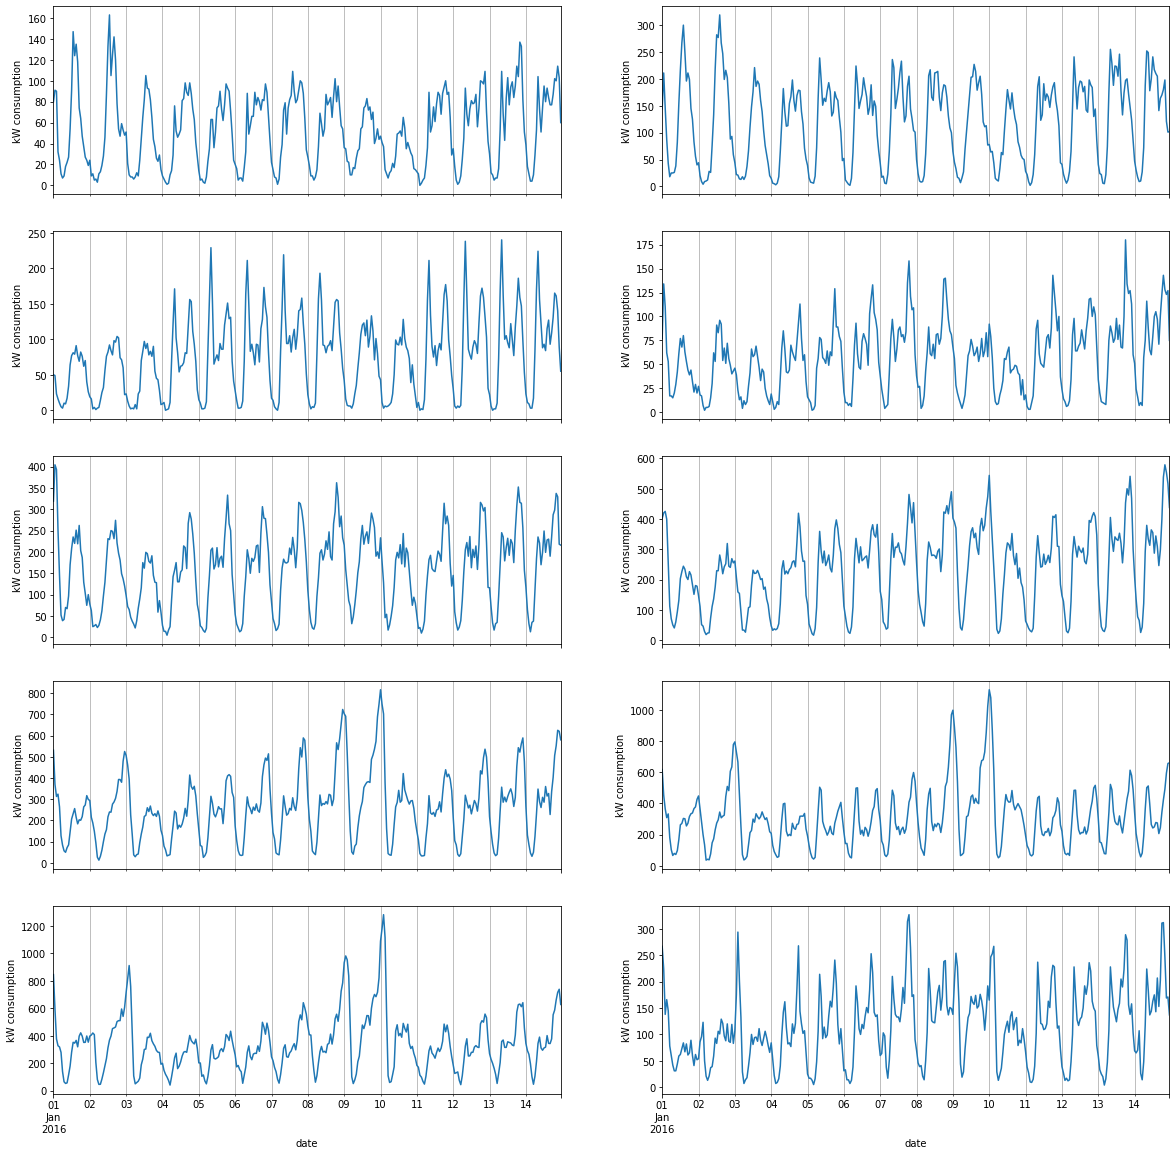

In [12]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    timeseries[i].loc["2016-01-01":"2016-01-14"].plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("kW consumption")   
    axx[i].grid(which='minor', axis='x')

#### Train test split

In [13]:
# we use 1 hour frequency for the time series
freq = '1H'

# we predict for 7 days
prediction_length = 7 * 24

# we also use 7 days as context length, this is the number of state updates accomplished before making predictions
context_length = 7 * 24

In [14]:
#start_dataset = pd.Timestamp("2016-04-24 00:00:00", freq=freq)
start_dataset = pd.Timestamp("2016-04-01 00:00:00", freq=freq)
end_training = pd.Timestamp("2016-05-02 00:00:00", freq=freq)

In [15]:
training_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training - timedelta(hours=25)].tolist()  # We use -1, because pandas indexing includes the upper bound 
    }
    for ts in timeseries
]
print(len(training_data))

102


In [16]:
for ts in timeseries[:1]:
    tmp = ts[start_dataset:end_training - timedelta(hours=25)]
    print(tmp)
    print(tmp[0])
    print(tmp[-1])

Time
2016-04-01 00:00:00     46.0
2016-04-01 01:00:00     25.0
2016-04-01 02:00:00     12.0
2016-04-01 03:00:00      8.0
2016-04-01 04:00:00      9.0
2016-04-01 05:00:00      7.0
2016-04-01 06:00:00     16.0
2016-04-01 07:00:00     43.0
2016-04-01 08:00:00     70.0
2016-04-01 09:00:00     59.0
2016-04-01 10:00:00     72.0
2016-04-01 11:00:00     86.0
2016-04-01 12:00:00    110.0
2016-04-01 13:00:00    104.0
2016-04-01 14:00:00     93.0
2016-04-01 15:00:00    111.0
2016-04-01 16:00:00     83.0
2016-04-01 17:00:00    110.0
2016-04-01 18:00:00    133.0
2016-04-01 19:00:00    116.0
2016-04-01 20:00:00     80.0
2016-04-01 21:00:00     85.0
2016-04-01 22:00:00     92.0
2016-04-01 23:00:00    107.0
2016-04-02 00:00:00     49.0
2016-04-02 01:00:00     29.0
2016-04-02 02:00:00     29.0
2016-04-02 03:00:00     10.0
2016-04-02 04:00:00      5.0
2016-04-02 05:00:00      4.0
                       ...  
2016-04-29 18:00:00    133.0
2016-04-29 19:00:00    114.0
2016-04-29 20:00:00    100.0
2016-04-2

In [17]:
for ts in timeseries:
    tmp=ts[start_dataset:end_training - timedelta(hours=25)].tolist() 
    print(len(tmp))

720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720
720


In [18]:
num_test_windows = 4

test_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training + timedelta(hours=k * prediction_length-k)].tolist()
    }
    for k in range(1, num_test_windows + 1) 
    for ts in timeseries
]
print(len(test_data))

408


In [19]:
for k in range(1, num_test_windows + 1):
    for ts in timeseries[:1]:
        print(end_training + timedelta(days=k * 7))
        print(ts[start_dataset:end_training + timedelta(hours=k * prediction_length-k)])
        #print(len(ts[start_dataset:end_training + timedelta(days=k * prediction_length)]))

2016-05-09 00:00:00
Time
2016-04-01 00:00:00     46.0
2016-04-01 01:00:00     25.0
2016-04-01 02:00:00     12.0
2016-04-01 03:00:00      8.0
2016-04-01 04:00:00      9.0
2016-04-01 05:00:00      7.0
2016-04-01 06:00:00     16.0
2016-04-01 07:00:00     43.0
2016-04-01 08:00:00     70.0
2016-04-01 09:00:00     59.0
2016-04-01 10:00:00     72.0
2016-04-01 11:00:00     86.0
2016-04-01 12:00:00    110.0
2016-04-01 13:00:00    104.0
2016-04-01 14:00:00     93.0
2016-04-01 15:00:00    111.0
2016-04-01 16:00:00     83.0
2016-04-01 17:00:00    110.0
2016-04-01 18:00:00    133.0
2016-04-01 19:00:00    116.0
2016-04-01 20:00:00     80.0
2016-04-01 21:00:00     85.0
2016-04-01 22:00:00     92.0
2016-04-01 23:00:00    107.0
2016-04-02 00:00:00     49.0
2016-04-02 01:00:00     29.0
2016-04-02 02:00:00     29.0
2016-04-02 03:00:00     10.0
2016-04-02 04:00:00      5.0
2016-04-02 05:00:00      4.0
                       ...  
2016-05-07 18:00:00     95.0
2016-05-07 19:00:00    109.0
2016-05-07 20:00:0

#### Data to file

In [20]:
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

In [21]:
%%time
write_dicts_to_file(os.path.join(output_data_path,"train.json"), training_data)
write_dicts_to_file(os.path.join(output_data_path,"test.json"), test_data)

Wall time: 145 ms


### Start working with sagemaker: load data to S3

In [22]:
import boto3
import s3fs
import sagemaker

In [23]:
sagemaker_session = sagemaker.Session()

In [24]:
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = 'deepar-YT-simple-notebook'    # prefix used for all data stored within the bucket

In [25]:
region = sagemaker_session.boto_region_name

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

In [26]:
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


In [27]:
s3 = boto3.resource('s3')
def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith('s3://')
    split = s3_path.split('/')
    bucket = split[2]
    path = '/'.join(split[3:])
    buk = s3.Bucket(bucket)
    
    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print('File s3://{}/{} already exists.\nSet override to upload anyway.\n'.format(s3_bucket, s3_path))
            return
        else:
            print('Overwriting existing file')
    with open(local_file, 'rb') as data:
        print('Uploading file to {}'.format(s3_path))
        buk.put_object(Key=path, Body=data)

In [28]:
copy_to_s3(os.path.join(output_data_path,"train.json"), s3_data_path + "/train/train.json", override=True)
copy_to_s3(os.path.join(output_data_path,"test.json"), s3_data_path + "/test/test.json", override=True)

Overwriting existing file
Uploading file to s3://sagemaker-us-west-2-676236127588/deepar-YT-simple-notebook/data/train/train.json
Overwriting existing file
Uploading file to s3://sagemaker-us-west-2-676236127588/deepar-YT-simple-notebook/data/test/test.json


In [29]:
s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(s3_data_path + "/train/train.json", 'rb') as fp:
    print(fp.readline().decode("utf-8")[:100] + "...")

{"start": "2016-04-01 00:00:00", "target": [46.0, 25.0, 12.0, 8.0, 9.0, 7.0, 16.0, 43.0, 70.0, 59.0,...


### Start working with sagemaker: set training job

In [30]:
estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='deepar-YT-simple-notebook',
    output_path=s3_output_path
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [31]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length)
}

In [32]:
estimator.set_hyperparameters(**hyperparameters)

In [33]:
#%%time
data_channels = {
    "train": "{}/train/train.json".format(s3_data_path),
    "test": "{}/test/test.json".format(s3_data_path)
}

estimator.fit(inputs=data_channels, wait=True)

2020-12-05 19:11:44 Starting - Starting the training job...
2020-12-05 19:11:45 Starting - Launching requested ML instances......
2020-12-05 19:13:12 Starting - Preparing the instances for training...
2020-12-05 19:14:02 Downloading - Downloading input data...
2020-12-05 19:14:36 Training - Downloading the training image..Arguments: train
[12/05/2020 19:14:54 INFO 140629789808448] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[12/05/2020 19:14:54 I

[12/05/2020 19:15:23 INFO 140629789808448] Epoch[5] Batch[5] avg_epoch_loss=4.231206
[12/05/2020 19:15:23 INFO 140629789808448] #quality_metric: host=algo-1, epoch=5, batch=5 train loss <loss>=4.23120609919
[12/05/2020 19:15:23 INFO 140629789808448] Epoch[5] Batch [5]#011Speed: 155.53 samples/sec#011loss=4.231206
[12/05/2020 19:15:25 INFO 140629789808448] processed a total of 622 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4378.865957260132, "sum": 4378.865957260132, "min": 4378.865957260132}}, "EndTime": 1607195725.25883, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607195720.879404}

[12/05/2020 19:15:25 INFO 140629789808448] #throughput_metric: host=algo-1, train throughput=142.040914053 records/second
[12/05/2020 19:15:25 INFO 140629789808448] #progress_metric: host=algo-1, completed 1 % of epochs
[12/05/2020 19:15:25 INFO 140629789808448] #quality_metric: host=algo-1, epoch=5, train loss <loss>=4.16046912

[12/05/2020 19:15:49 INFO 140629789808448] Epoch[11] Batch[0] avg_epoch_loss=3.952876
[12/05/2020 19:15:49 INFO 140629789808448] #quality_metric: host=algo-1, epoch=11, batch=0 train loss <loss>=3.95287561417
[12/05/2020 19:15:51 INFO 140629789808448] Epoch[11] Batch[5] avg_epoch_loss=3.946895
[12/05/2020 19:15:51 INFO 140629789808448] #quality_metric: host=algo-1, epoch=11, batch=5 train loss <loss>=3.9468947649
[12/05/2020 19:15:51 INFO 140629789808448] Epoch[11] Batch [5]#011Speed: 156.81 samples/sec#011loss=3.946895
[12/05/2020 19:15:53 INFO 140629789808448] Epoch[11] Batch[10] avg_epoch_loss=3.762543
[12/05/2020 19:15:53 INFO 140629789808448] #quality_metric: host=algo-1, epoch=11, batch=10 train loss <loss>=3.54132013321
[12/05/2020 19:15:53 INFO 140629789808448] Epoch[11] Batch [10]#011Speed: 153.87 samples/sec#011loss=3.541320
[12/05/2020 19:15:53 INFO 140629789808448] processed a total of 648 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4748.725175857544, 

[12/05/2020 19:16:21 INFO 140629789808448] processed a total of 614 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4304.861068725586, "sum": 4304.861068725586, "min": 4304.861068725586}}, "EndTime": 1607195781.167751, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607195776.862809}

[12/05/2020 19:16:21 INFO 140629789808448] #throughput_metric: host=algo-1, train throughput=142.624718329 records/second
[12/05/2020 19:16:21 INFO 140629789808448] #progress_metric: host=algo-1, completed 4 % of epochs
[12/05/2020 19:16:21 INFO 140629789808448] #quality_metric: host=algo-1, epoch=17, train loss <loss>=3.73258731365
[12/05/2020 19:16:21 INFO 140629789808448] loss did not improve
[12/05/2020 19:16:21 INFO 140629789808448] Epoch[18] Batch[0] avg_epoch_loss=3.744789
[12/05/2020 19:16:21 INFO 140629789808448] #quality_metric: host=algo-1, epoch=18, batch=0 train loss <loss>=3.74478912354
[12/05/2020 19:16:23 INFO 1406297898

[12/05/2020 19:16:46 INFO 140629789808448] Epoch[23] Batch[5] avg_epoch_loss=3.699487
[12/05/2020 19:16:46 INFO 140629789808448] #quality_metric: host=algo-1, epoch=23, batch=5 train loss <loss>=3.69948716958
[12/05/2020 19:16:46 INFO 140629789808448] Epoch[23] Batch [5]#011Speed: 155.99 samples/sec#011loss=3.699487
[12/05/2020 19:16:48 INFO 140629789808448] Epoch[23] Batch[10] avg_epoch_loss=3.660907
[12/05/2020 19:16:48 INFO 140629789808448] #quality_metric: host=algo-1, epoch=23, batch=10 train loss <loss>=3.61461186409
[12/05/2020 19:16:48 INFO 140629789808448] Epoch[23] Batch [10]#011Speed: 153.79 samples/sec#011loss=3.614612
[12/05/2020 19:16:48 INFO 140629789808448] processed a total of 692 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4757.985830307007, "sum": 4757.985830307007, "min": 4757.985830307007}}, "EndTime": 1607195808.959817, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607195804.201279}

[12/0

[12/05/2020 19:17:13 INFO 140629789808448] Epoch[29] Batch[0] avg_epoch_loss=3.598850
[12/05/2020 19:17:13 INFO 140629789808448] #quality_metric: host=algo-1, epoch=29, batch=0 train loss <loss>=3.59884977341
[12/05/2020 19:17:15 INFO 140629789808448] Epoch[29] Batch[5] avg_epoch_loss=3.570033
[12/05/2020 19:17:15 INFO 140629789808448] #quality_metric: host=algo-1, epoch=29, batch=5 train loss <loss>=3.57003303369
[12/05/2020 19:17:15 INFO 140629789808448] Epoch[29] Batch [5]#011Speed: 155.90 samples/sec#011loss=3.570033
[12/05/2020 19:17:16 INFO 140629789808448] processed a total of 627 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4345.968961715698, "sum": 4345.968961715698, "min": 4345.968961715698}}, "EndTime": 1607195836.913938, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607195832.5679}

[12/05/2020 19:17:16 INFO 140629789808448] #throughput_metric: host=algo-1, train throughput=144.267801311 records/seco

[12/05/2020 19:17:45 INFO 140629789808448] Epoch[36] Batch[0] avg_epoch_loss=3.491797
[12/05/2020 19:17:45 INFO 140629789808448] #quality_metric: host=algo-1, epoch=36, batch=0 train loss <loss>=3.49179673195
[12/05/2020 19:17:47 INFO 140629789808448] Epoch[36] Batch[5] avg_epoch_loss=3.555483
[12/05/2020 19:17:47 INFO 140629789808448] #quality_metric: host=algo-1, epoch=36, batch=5 train loss <loss>=3.5554826657
[12/05/2020 19:17:47 INFO 140629789808448] Epoch[36] Batch [5]#011Speed: 155.47 samples/sec#011loss=3.555483
[12/05/2020 19:17:49 INFO 140629789808448] Epoch[36] Batch[10] avg_epoch_loss=3.463512
[12/05/2020 19:17:49 INFO 140629789808448] #quality_metric: host=algo-1, epoch=36, batch=10 train loss <loss>=3.35314745903
[12/05/2020 19:17:49 INFO 140629789808448] Epoch[36] Batch [10]#011Speed: 152.32 samples/sec#011loss=3.353147
[12/05/2020 19:17:49 INFO 140629789808448] processed a total of 651 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4761.615037918091, 

[12/05/2020 19:18:13 INFO 140629789808448] Epoch[42] Batch[0] avg_epoch_loss=3.452979
[12/05/2020 19:18:13 INFO 140629789808448] #quality_metric: host=algo-1, epoch=42, batch=0 train loss <loss>=3.45297932625
[12/05/2020 19:18:15 INFO 140629789808448] Epoch[42] Batch[5] avg_epoch_loss=3.560276
[12/05/2020 19:18:15 INFO 140629789808448] #quality_metric: host=algo-1, epoch=42, batch=5 train loss <loss>=3.56027587255
[12/05/2020 19:18:15 INFO 140629789808448] Epoch[42] Batch [5]#011Speed: 154.85 samples/sec#011loss=3.560276
[12/05/2020 19:18:16 INFO 140629789808448] processed a total of 607 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4369.959115982056, "sum": 4369.959115982056, "min": 4369.959115982056}}, "EndTime": 1607195896.80815, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607195892.437661}

[12/05/2020 19:18:16 INFO 140629789808448] #throughput_metric: host=algo-1, train throughput=138.898233252 records/sec

[12/05/2020 19:18:46 INFO 140629789808448] Epoch[49] Batch[5] avg_epoch_loss=3.543184
[12/05/2020 19:18:46 INFO 140629789808448] #quality_metric: host=algo-1, epoch=49, batch=5 train loss <loss>=3.54318435987
[12/05/2020 19:18:46 INFO 140629789808448] Epoch[49] Batch [5]#011Speed: 156.78 samples/sec#011loss=3.543184
[12/05/2020 19:18:48 INFO 140629789808448] Epoch[49] Batch[10] avg_epoch_loss=3.492333
[12/05/2020 19:18:48 INFO 140629789808448] #quality_metric: host=algo-1, epoch=49, batch=10 train loss <loss>=3.4313103199
[12/05/2020 19:18:48 INFO 140629789808448] Epoch[49] Batch [10]#011Speed: 155.55 samples/sec#011loss=3.431310
[12/05/2020 19:18:48 INFO 140629789808448] processed a total of 684 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4726.577043533325, "sum": 4726.577043533325, "min": 4726.577043533325}}, "EndTime": 1607195928.855038, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607195924.122975}

[12/05

[12/05/2020 19:19:12 INFO 140629789808448] Epoch[54] Batch[10] avg_epoch_loss=3.526475
[12/05/2020 19:19:12 INFO 140629789808448] #quality_metric: host=algo-1, epoch=54, batch=10 train loss <loss>=3.38995480537
[12/05/2020 19:19:12 INFO 140629789808448] Epoch[54] Batch [10]#011Speed: 152.08 samples/sec#011loss=3.389955
[12/05/2020 19:19:12 INFO 140629789808448] processed a total of 647 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4744.218111038208, "sum": 4744.218111038208, "min": 4744.218111038208}}, "EndTime": 1607195952.410054, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607195947.665278}

[12/05/2020 19:19:12 INFO 140629789808448] #throughput_metric: host=algo-1, train throughput=136.372876412 records/second
[12/05/2020 19:19:12 INFO 140629789808448] #progress_metric: host=algo-1, completed 13 % of epochs
[12/05/2020 19:19:12 INFO 140629789808448] #quality_metric: host=algo-1, epoch=54, train loss <loss>=3

[12/05/2020 19:19:38 INFO 140629789808448] Epoch[60] Batch[5] avg_epoch_loss=3.437177
[12/05/2020 19:19:38 INFO 140629789808448] #quality_metric: host=algo-1, epoch=60, batch=5 train loss <loss>=3.43717670441
[12/05/2020 19:19:38 INFO 140629789808448] Epoch[60] Batch [5]#011Speed: 156.33 samples/sec#011loss=3.437177
[12/05/2020 19:19:39 INFO 140629789808448] processed a total of 616 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4326.231956481934, "sum": 4326.231956481934, "min": 4326.231956481934}}, "EndTime": 1607195979.795348, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607195975.468618}

[12/05/2020 19:19:39 INFO 140629789808448] #throughput_metric: host=algo-1, train throughput=142.38120035 records/second
[12/05/2020 19:19:39 INFO 140629789808448] #progress_metric: host=algo-1, completed 15 % of epochs
[12/05/2020 19:19:39 INFO 140629789808448] #quality_metric: host=algo-1, epoch=60, train loss <loss>=3.471

[12/05/2020 19:20:11 INFO 140629789808448] processed a total of 618 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4366.77885055542, "sum": 4366.77885055542, "min": 4366.77885055542}}, "EndTime": 1607196011.500413, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607196007.133155}

[12/05/2020 19:20:11 INFO 140629789808448] #throughput_metric: host=algo-1, train throughput=141.519056084 records/second
[12/05/2020 19:20:11 INFO 140629789808448] #progress_metric: host=algo-1, completed 17 % of epochs
[12/05/2020 19:20:11 INFO 140629789808448] #quality_metric: host=algo-1, epoch=67, train loss <loss>=3.48246700764
[12/05/2020 19:20:11 INFO 140629789808448] loss did not improve
[12/05/2020 19:20:12 INFO 140629789808448] Epoch[68] Batch[0] avg_epoch_loss=3.367225
[12/05/2020 19:20:12 INFO 140629789808448] #quality_metric: host=algo-1, epoch=68, batch=0 train loss <loss>=3.3672246933
[12/05/2020 19:20:14 INFO 1406297898084

[12/05/2020 19:20:37 INFO 140629789808448] Epoch[73] Batch[5] avg_epoch_loss=3.614648
[12/05/2020 19:20:37 INFO 140629789808448] #quality_metric: host=algo-1, epoch=73, batch=5 train loss <loss>=3.61464782556
[12/05/2020 19:20:37 INFO 140629789808448] Epoch[73] Batch [5]#011Speed: 155.64 samples/sec#011loss=3.614648
[12/05/2020 19:20:39 INFO 140629789808448] Epoch[73] Batch[10] avg_epoch_loss=3.540664
[12/05/2020 19:20:39 INFO 140629789808448] #quality_metric: host=algo-1, epoch=73, batch=10 train loss <loss>=3.45188379288
[12/05/2020 19:20:39 INFO 140629789808448] Epoch[73] Batch [10]#011Speed: 154.94 samples/sec#011loss=3.451884
[12/05/2020 19:20:39 INFO 140629789808448] processed a total of 656 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4732.596874237061, "sum": 4732.596874237061, "min": 4732.596874237061}}, "EndTime": 1607196039.580128, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607196034.846977}

[12/0

[12/05/2020 19:21:15 INFO 140629789808448] Epoch[82] Batch[0] avg_epoch_loss=3.430782
[12/05/2020 19:21:15 INFO 140629789808448] #quality_metric: host=algo-1, epoch=82, batch=0 train loss <loss>=3.4307820797
[12/05/2020 19:21:17 INFO 140629789808448] Epoch[82] Batch[5] avg_epoch_loss=3.430450
[12/05/2020 19:21:17 INFO 140629789808448] #quality_metric: host=algo-1, epoch=82, batch=5 train loss <loss>=3.4304497242
[12/05/2020 19:21:17 INFO 140629789808448] Epoch[82] Batch [5]#011Speed: 155.12 samples/sec#011loss=3.430450
[12/05/2020 19:21:18 INFO 140629789808448] processed a total of 572 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 3917.0188903808594, "sum": 3917.0188903808594, "min": 3917.0188903808594}}, "EndTime": 1607196078.580943, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607196074.663354}

[12/05/2020 19:21:18 INFO 140629789808448] #throughput_metric: host=algo-1, train throughput=146.023901342 records/s

[12/05/2020 19:21:49 INFO 140629789808448] processed a total of 617 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4303.7049770355225, "sum": 4303.7049770355225, "min": 4303.7049770355225}}, "EndTime": 1607196109.263563, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607196104.959316}

[12/05/2020 19:21:49 INFO 140629789808448] #throughput_metric: host=algo-1, train throughput=143.359810535 records/second
[12/05/2020 19:21:49 INFO 140629789808448] #progress_metric: host=algo-1, completed 22 % of epochs
[12/05/2020 19:21:49 INFO 140629789808448] #quality_metric: host=algo-1, epoch=89, train loss <loss>=3.60190958977
[12/05/2020 19:21:49 INFO 140629789808448] loss did not improve
[12/05/2020 19:21:49 INFO 140629789808448] Epoch[90] Batch[0] avg_epoch_loss=3.492837
[12/05/2020 19:21:49 INFO 140629789808448] #quality_metric: host=algo-1, epoch=90, batch=0 train loss <loss>=3.49283695221
[12/05/2020 19:21:51 INFO 140629

[12/05/2020 19:22:16 INFO 140629789808448] processed a total of 615 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4343.283891677856, "sum": 4343.283891677856, "min": 4343.283891677856}}, "EndTime": 1607196136.711356, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607196132.367615}

[12/05/2020 19:22:16 INFO 140629789808448] #throughput_metric: host=algo-1, train throughput=141.592090902 records/second
[12/05/2020 19:22:16 INFO 140629789808448] #progress_metric: host=algo-1, completed 24 % of epochs
[12/05/2020 19:22:16 INFO 140629789808448] #quality_metric: host=algo-1, epoch=95, train loss <loss>=3.54076955318
[12/05/2020 19:22:16 INFO 140629789808448] loss did not improve
[12/05/2020 19:22:17 INFO 140629789808448] Epoch[96] Batch[0] avg_epoch_loss=3.377490
[12/05/2020 19:22:17 INFO 140629789808448] #quality_metric: host=algo-1, epoch=96, batch=0 train loss <loss>=3.37749004364
[12/05/2020 19:22:19 INFO 140629789

### Create endpoint and predictor

In [34]:
from sagemaker.serializers import IdentitySerializer

In [35]:
class DeepARPredictor(sagemaker.predictor.Predictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, 
                         #serializer=JSONSerializer(),
                         serializer=IdentitySerializer(content_type="application/json"),
                         **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + ts.index.freq
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)
        
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.date_range(start=prediction_time, freq=freq, periods=prediction_length)
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

In [36]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    predictor_cls=DeepARPredictor)

---------------!

In [37]:
start_predict = pd.Timestamp("2016-05-01 00:00:00", freq=freq) - timedelta(hours=1)
prd_example = predictor.predict(ts=timeseries[0][:start_predict], quantiles=[0.10, 0.5, 0.90])#.head()

In [38]:
prd_example.shape

(168, 3)

In [39]:
prd_example.head()

0.1        0.9        0.5
2016-05-01 00:00:00  28.624966  81.736748  57.661091
2016-05-01 01:00:00  11.744020  46.568958  28.297060
2016-05-01 02:00:00   2.024587  26.466539  11.789145
2016-05-01 03:00:00  -3.449174  16.044386   4.580822
2016-05-01 04:00:00  -7.260986   8.419019   0.207154

In [40]:
prd_example.columns = ['q10', 'q90', 'prd_median']

### Let Calculate RMSE

In [41]:
start_predict = pd.Timestamp("2016-05-01 00:00:00", freq=freq) - timedelta(hours=1)
timeseries[0][start_predict + timedelta(hours=1):start_predict+timedelta(hours=prediction_length)]

Time
2016-05-01 00:00:00     71.0
2016-05-01 01:00:00     37.0
2016-05-01 02:00:00     10.0
2016-05-01 03:00:00     14.0
2016-05-01 04:00:00      6.0
2016-05-01 05:00:00      8.0
2016-05-01 06:00:00     10.0
2016-05-01 07:00:00     21.0
2016-05-01 08:00:00     17.0
2016-05-01 09:00:00     23.0
2016-05-01 10:00:00     51.0
2016-05-01 11:00:00     73.0
2016-05-01 12:00:00     99.0
2016-05-01 13:00:00     96.0
2016-05-01 14:00:00     96.0
2016-05-01 15:00:00    102.0
2016-05-01 16:00:00     91.0
2016-05-01 17:00:00     85.0
2016-05-01 18:00:00     70.0
2016-05-01 19:00:00     55.0
2016-05-01 20:00:00     48.0
2016-05-01 21:00:00     32.0
2016-05-01 22:00:00     21.0
2016-05-01 23:00:00     20.0
2016-05-02 00:00:00     12.0
2016-05-02 01:00:00      4.0
2016-05-02 02:00:00      5.0
2016-05-02 03:00:00      3.0
2016-05-02 04:00:00      5.0
2016-05-02 05:00:00      7.0
                       ...  
2016-05-06 18:00:00    121.0
2016-05-06 19:00:00    102.0
2016-05-06 20:00:00     94.0
2016-05-0

In [42]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [43]:
rmse_list = []
prd_list = []
act_list = []
for ts in timeseries:
    prd_dt = predictor.predict(ts=ts[:start_predict], quantiles=[0.1,0.5, 0.9])
    prd = prd_dt['0.5'].tolist()
    act = ts[start_predict + timedelta(hours=1):start_predict+timedelta(hours=prediction_length)].tolist()
    rmse_list.append(sqrt(mean_squared_error(act, prd)))
    prd_list.append(prd_dt)
    act_list.append(act)

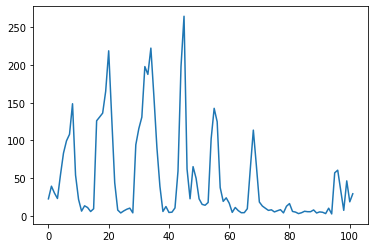

In [44]:
plt.plot(rmse_list)

In [45]:
def mape(act,prd):
    l = list(map(lambda a, p: abs((a-p)/a) if abs(a)>0.00001 else 0, act,prd))
    return(np.mean(l))

In [46]:
mape_list = []
for act, prd_dt in zip(act_list, prd_list):
    mape_list.append(mape(act, prd_dt['0.5'].tolist()))

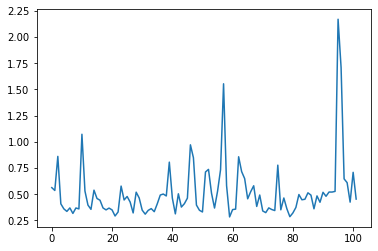

In [47]:
plt.plot(mape_list)

#### Plot for selected timeseries

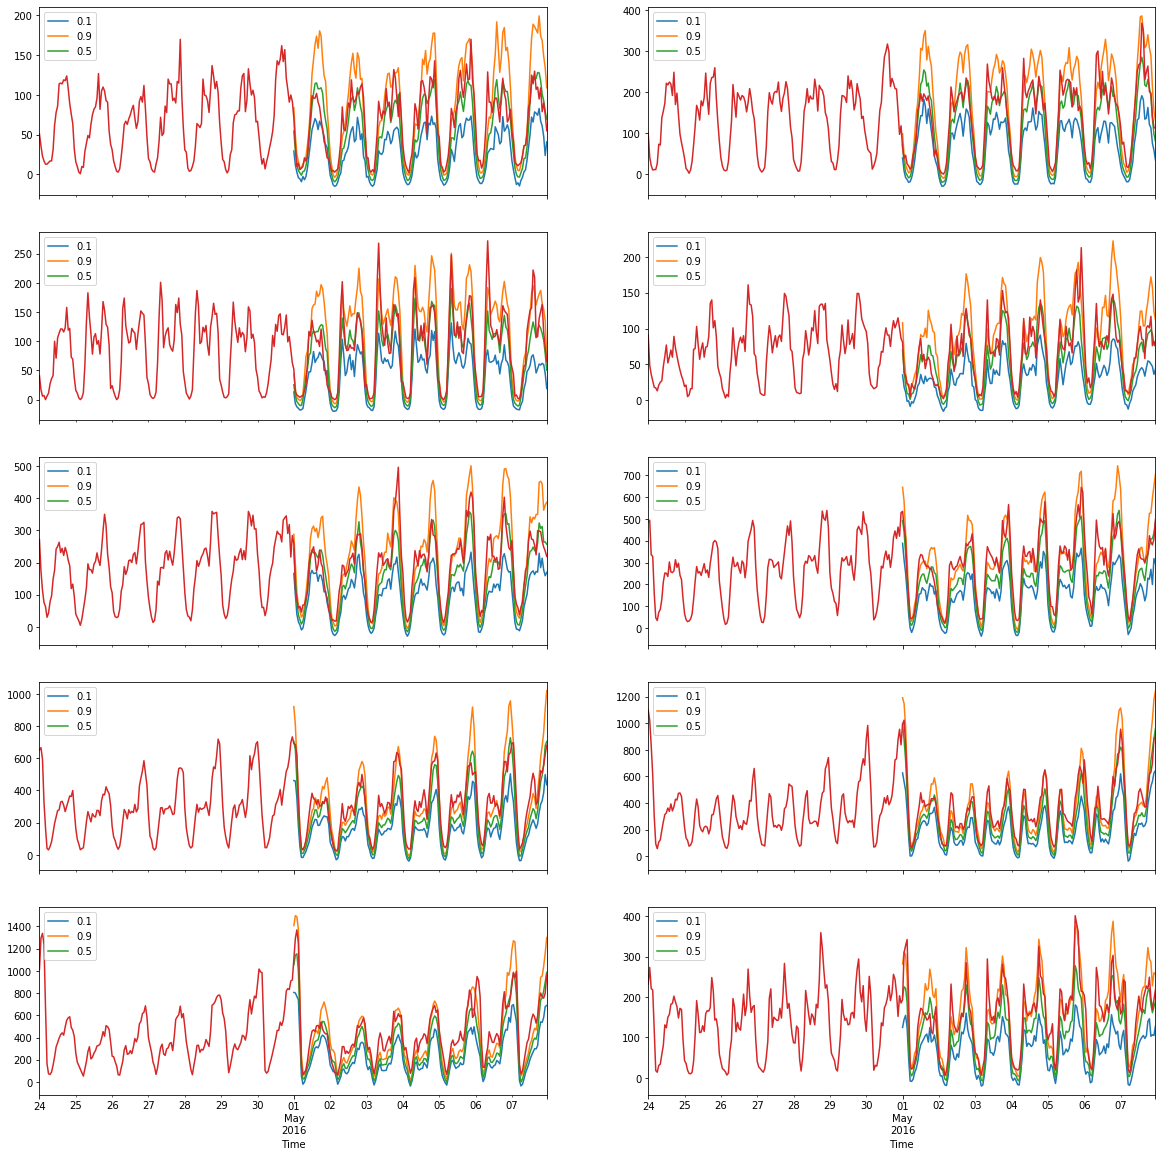

In [48]:
i = 0
start_dataset = pd.Timestamp("2016-04-24 00:00:00", freq=freq)

fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    ts = timeseries[i][start_dataset:start_predict+timedelta(hours=prediction_length)]
    prd = prd_list[i]
#figsize=(20, 20)
    prd.plot(ax=axx[i])
    ts.plot(ax=axx[i])


### Delete Endpoint

In [49]:
predictor.delete_endpoint()

## Sagemaker: context 2x longer than it was

In [50]:
name_for_modeling = 'deepar-YT-simple-notebook2xconext'
start_dataset = pd.Timestamp("2016-04-24 00:00:00", freq=freq)

In [51]:
estimator_2x_context = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name=name_for_modeling,
    output_path=s3_output_path
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [52]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(2*context_length),
    "prediction_length": str(prediction_length)
}

In [53]:
estimator_2x_context.set_hyperparameters(**hyperparameters)

In [54]:
#%%time
data_channels = {
    "train": "{}/train/train.json".format(s3_data_path),
    "test": "{}/test/test.json".format(s3_data_path)
}

estimator_2x_context.fit(inputs=data_channels, wait=True)

2020-12-05 19:42:07 Starting - Starting the training job...
2020-12-05 19:42:09 Starting - Launching requested ML instances......
2020-12-05 19:43:23 Starting - Preparing the instances for training...
2020-12-05 19:44:13 Downloading - Downloading input data...
2020-12-05 19:44:51 Training - Downloading the training image..Arguments: train
[12/05/2020 19:45:14 INFO 139830264035136] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[12/05/2020 19:45:14 I

[12/05/2020 19:45:46 INFO 139830264035136] Epoch[3] Batch[5] avg_epoch_loss=3.828085
[12/05/2020 19:45:46 INFO 139830264035136] #quality_metric: host=algo-1, epoch=3, batch=5 train loss <loss>=3.82808482647
[12/05/2020 19:45:46 INFO 139830264035136] Epoch[3] Batch [5]#011Speed: 108.95 samples/sec#011loss=3.828085
[12/05/2020 19:45:49 INFO 139830264035136] Epoch[3] Batch[10] avg_epoch_loss=3.615607
[12/05/2020 19:45:49 INFO 139830264035136] #quality_metric: host=algo-1, epoch=3, batch=10 train loss <loss>=3.36063346863
[12/05/2020 19:45:49 INFO 139830264035136] Epoch[3] Batch [10]#011Speed: 106.39 samples/sec#011loss=3.360633
[12/05/2020 19:45:49 INFO 139830264035136] processed a total of 652 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6770.441055297852, "sum": 6770.441055297852, "min": 6770.441055297852}}, "EndTime": 1607197549.516718, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607197542.746198}

[12/05/2020

[12/05/2020 19:46:14 INFO 139830264035136] Epoch[7] Batch[5] avg_epoch_loss=3.432734
[12/05/2020 19:46:14 INFO 139830264035136] #quality_metric: host=algo-1, epoch=7, batch=5 train loss <loss>=3.43273373445
[12/05/2020 19:46:14 INFO 139830264035136] Epoch[7] Batch [5]#011Speed: 104.75 samples/sec#011loss=3.432734
[12/05/2020 19:46:16 INFO 139830264035136] processed a total of 605 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6273.051977157593, "sum": 6273.051977157593, "min": 6273.051977157593}}, "EndTime": 1607197576.953242, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607197570.67961}

[12/05/2020 19:46:16 INFO 139830264035136] #throughput_metric: host=algo-1, train throughput=96.4421130252 records/second
[12/05/2020 19:46:16 INFO 139830264035136] #progress_metric: host=algo-1, completed 2 % of epochs
[12/05/2020 19:46:16 INFO 139830264035136] #quality_metric: host=algo-1, epoch=7, train loss <loss>=3.49991044

[12/05/2020 19:46:47 INFO 139830264035136] Epoch[12] Batch[5] avg_epoch_loss=3.265199
[12/05/2020 19:46:47 INFO 139830264035136] #quality_metric: host=algo-1, epoch=12, batch=5 train loss <loss>=3.26519874732
[12/05/2020 19:46:47 INFO 139830264035136] Epoch[12] Batch [5]#011Speed: 106.66 samples/sec#011loss=3.265199
[12/05/2020 19:46:49 INFO 139830264035136] processed a total of 624 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6303.107023239136, "sum": 6303.107023239136, "min": 6303.107023239136}}, "EndTime": 1607197609.812473, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607197603.508829}

[12/05/2020 19:46:49 INFO 139830264035136] #throughput_metric: host=algo-1, train throughput=98.9970649766 records/second
[12/05/2020 19:46:49 INFO 139830264035136] #progress_metric: host=algo-1, completed 3 % of epochs
[12/05/2020 19:46:49 INFO 139830264035136] #quality_metric: host=algo-1, epoch=12, train loss <loss>=3.286

[12/05/2020 19:47:33 INFO 139830264035136] Epoch[19] Batch[5] avg_epoch_loss=3.299551
[12/05/2020 19:47:33 INFO 139830264035136] #quality_metric: host=algo-1, epoch=19, batch=5 train loss <loss>=3.29955148697
[12/05/2020 19:47:33 INFO 139830264035136] Epoch[19] Batch [5]#011Speed: 107.24 samples/sec#011loss=3.299551
[12/05/2020 19:47:36 INFO 139830264035136] Epoch[19] Batch[10] avg_epoch_loss=3.239695
[12/05/2020 19:47:36 INFO 139830264035136] #quality_metric: host=algo-1, epoch=19, batch=10 train loss <loss>=3.16786642075
[12/05/2020 19:47:36 INFO 139830264035136] Epoch[19] Batch [10]#011Speed: 107.12 samples/sec#011loss=3.167866
[12/05/2020 19:47:36 INFO 139830264035136] processed a total of 649 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6774.672031402588, "sum": 6774.672031402588, "min": 6774.672031402588}}, "EndTime": 1607197656.831166, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607197650.056419}

[12/0

[12/05/2020 19:48:07 INFO 139830264035136] Epoch[24] Batch[5] avg_epoch_loss=3.213023
[12/05/2020 19:48:07 INFO 139830264035136] #quality_metric: host=algo-1, epoch=24, batch=5 train loss <loss>=3.21302302678
[12/05/2020 19:48:07 INFO 139830264035136] Epoch[24] Batch [5]#011Speed: 106.45 samples/sec#011loss=3.213023
[12/05/2020 19:48:09 INFO 139830264035136] processed a total of 615 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6326.2341022491455, "sum": 6326.2341022491455, "min": 6326.2341022491455}}, "EndTime": 1607197689.639892, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607197683.313179}

[12/05/2020 19:48:09 INFO 139830264035136] #throughput_metric: host=algo-1, train throughput=97.2120867233 records/second
[12/05/2020 19:48:09 INFO 139830264035136] #progress_metric: host=algo-1, completed 6 % of epochs
[12/05/2020 19:48:09 INFO 139830264035136] #quality_metric: host=algo-1, epoch=24, train loss <loss>=3.

[12/05/2020 19:48:46 INFO 139830264035136] Epoch[30] Batch[5] avg_epoch_loss=3.209000
[12/05/2020 19:48:46 INFO 139830264035136] #quality_metric: host=algo-1, epoch=30, batch=5 train loss <loss>=3.20899991194
[12/05/2020 19:48:46 INFO 139830264035136] Epoch[30] Batch [5]#011Speed: 106.46 samples/sec#011loss=3.209000
[12/05/2020 19:48:49 INFO 139830264035136] processed a total of 620 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6268.60785484314, "sum": 6268.60785484314, "min": 6268.60785484314}}, "EndTime": 1607197729.006546, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607197722.737431}

[12/05/2020 19:48:49 INFO 139830264035136] #throughput_metric: host=algo-1, train throughput=98.9032758356 records/second
[12/05/2020 19:48:49 INFO 139830264035136] #progress_metric: host=algo-1, completed 7 % of epochs
[12/05/2020 19:48:49 INFO 139830264035136] #quality_metric: host=algo-1, epoch=30, train loss <loss>=3.204080

[12/05/2020 19:49:32 INFO 139830264035136] Epoch[37] Batch[5] avg_epoch_loss=3.110727
[12/05/2020 19:49:32 INFO 139830264035136] #quality_metric: host=algo-1, epoch=37, batch=5 train loss <loss>=3.11072663466
[12/05/2020 19:49:32 INFO 139830264035136] Epoch[37] Batch [5]#011Speed: 106.53 samples/sec#011loss=3.110727
[12/05/2020 19:49:35 INFO 139830264035136] Epoch[37] Batch[10] avg_epoch_loss=3.089988
[12/05/2020 19:49:35 INFO 139830264035136] #quality_metric: host=algo-1, epoch=37, batch=10 train loss <loss>=3.06510205269
[12/05/2020 19:49:35 INFO 139830264035136] Epoch[37] Batch [10]#011Speed: 106.81 samples/sec#011loss=3.065102
[12/05/2020 19:49:35 INFO 139830264035136] processed a total of 656 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6803.824901580811, "sum": 6803.824901580811, "min": 6803.824901580811}}, "EndTime": 1607197775.074958, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607197768.270608}

[12/0

[12/05/2020 19:50:12 INFO 139830264035136] Epoch[43] Batch[5] avg_epoch_loss=3.074258
[12/05/2020 19:50:12 INFO 139830264035136] #quality_metric: host=algo-1, epoch=43, batch=5 train loss <loss>=3.07425781091
[12/05/2020 19:50:12 INFO 139830264035136] Epoch[43] Batch [5]#011Speed: 107.86 samples/sec#011loss=3.074258
[12/05/2020 19:50:15 INFO 139830264035136] Epoch[43] Batch[10] avg_epoch_loss=3.045779
[12/05/2020 19:50:15 INFO 139830264035136] #quality_metric: host=algo-1, epoch=43, batch=10 train loss <loss>=3.01160411835
[12/05/2020 19:50:15 INFO 139830264035136] Epoch[43] Batch [10]#011Speed: 104.78 samples/sec#011loss=3.011604
[12/05/2020 19:50:15 INFO 139830264035136] processed a total of 683 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6848.706007003784, "sum": 6848.706007003784, "min": 6848.706007003784}}, "EndTime": 1607197815.319957, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607197808.470745}

[12/0

[12/05/2020 19:50:57 INFO 139830264035136] Epoch[50] Batch[5] avg_epoch_loss=3.083090
[12/05/2020 19:50:57 INFO 139830264035136] #quality_metric: host=algo-1, epoch=50, batch=5 train loss <loss>=3.08308990796
[12/05/2020 19:50:57 INFO 139830264035136] Epoch[50] Batch [5]#011Speed: 105.43 samples/sec#011loss=3.083090
[12/05/2020 19:50:59 INFO 139830264035136] processed a total of 639 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6228.555917739868, "sum": 6228.555917739868, "min": 6228.555917739868}}, "EndTime": 1607197859.650329, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607197853.421257}

[12/05/2020 19:50:59 INFO 139830264035136] #throughput_metric: host=algo-1, train throughput=102.589772013 records/second
[12/05/2020 19:50:59 INFO 139830264035136] #progress_metric: host=algo-1, completed 12 % of epochs
[12/05/2020 19:50:59 INFO 139830264035136] #quality_metric: host=algo-1, epoch=50, train loss <loss>=3.07

[12/05/2020 19:51:36 INFO 139830264035136] Epoch[56] Batch[5] avg_epoch_loss=3.120221
[12/05/2020 19:51:36 INFO 139830264035136] #quality_metric: host=algo-1, epoch=56, batch=5 train loss <loss>=3.12022078037
[12/05/2020 19:51:36 INFO 139830264035136] Epoch[56] Batch [5]#011Speed: 108.02 samples/sec#011loss=3.120221
[12/05/2020 19:51:38 INFO 139830264035136] processed a total of 629 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6192.0270919799805, "sum": 6192.0270919799805, "min": 6192.0270919799805}}, "EndTime": 1607197898.716942, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607197892.52446}

[12/05/2020 19:51:38 INFO 139830264035136] #throughput_metric: host=algo-1, train throughput=101.580013472 records/second
[12/05/2020 19:51:38 INFO 139830264035136] #progress_metric: host=algo-1, completed 14 % of epochs
[12/05/2020 19:51:38 INFO 139830264035136] #quality_metric: host=algo-1, epoch=56, train loss <loss>=3.

[12/05/2020 19:52:14 INFO 139830264035136] Epoch[62] Batch[5] avg_epoch_loss=3.151156
[12/05/2020 19:52:14 INFO 139830264035136] #quality_metric: host=algo-1, epoch=62, batch=5 train loss <loss>=3.15115563075
[12/05/2020 19:52:14 INFO 139830264035136] Epoch[62] Batch [5]#011Speed: 108.43 samples/sec#011loss=3.151156
[12/05/2020 19:52:17 INFO 139830264035136] processed a total of 600 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6230.381965637207, "sum": 6230.381965637207, "min": 6230.381965637207}}, "EndTime": 1607197937.250446, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607197931.019549}

[12/05/2020 19:52:17 INFO 139830264035136] #throughput_metric: host=algo-1, train throughput=96.3002255338 records/second
[12/05/2020 19:52:17 INFO 139830264035136] #progress_metric: host=algo-1, completed 15 % of epochs
[12/05/2020 19:52:17 INFO 139830264035136] #quality_metric: host=algo-1, epoch=62, train loss <loss>=3.26

[12/05/2020 19:53:00 INFO 139830264035136] Epoch[69] Batch[5] avg_epoch_loss=3.018933
[12/05/2020 19:53:00 INFO 139830264035136] #quality_metric: host=algo-1, epoch=69, batch=5 train loss <loss>=3.01893305779
[12/05/2020 19:53:00 INFO 139830264035136] Epoch[69] Batch [5]#011Speed: 108.65 samples/sec#011loss=3.018933
[12/05/2020 19:53:02 INFO 139830264035136] processed a total of 640 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6271.003007888794, "sum": 6271.003007888794, "min": 6271.003007888794}}, "EndTime": 1607197982.924402, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607197976.652908}

[12/05/2020 19:53:02 INFO 139830264035136] #throughput_metric: host=algo-1, train throughput=102.054843127 records/second
[12/05/2020 19:53:02 INFO 139830264035136] #progress_metric: host=algo-1, completed 17 % of epochs
[12/05/2020 19:53:02 INFO 139830264035136] #quality_metric: host=algo-1, epoch=69, train loss <loss>=3.02

[12/05/2020 19:53:38 INFO 139830264035136] Epoch[75] Batch[5] avg_epoch_loss=2.954062
[12/05/2020 19:53:38 INFO 139830264035136] #quality_metric: host=algo-1, epoch=75, batch=5 train loss <loss>=2.95406214396
[12/05/2020 19:53:38 INFO 139830264035136] Epoch[75] Batch [5]#011Speed: 107.48 samples/sec#011loss=2.954062
[12/05/2020 19:53:41 INFO 139830264035136] processed a total of 625 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6255.070924758911, "sum": 6255.070924758911, "min": 6255.070924758911}}, "EndTime": 1607198021.025028, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607198014.769392}

[12/05/2020 19:53:41 INFO 139830264035136] #throughput_metric: host=algo-1, train throughput=99.9167411311 records/second
[12/05/2020 19:53:41 INFO 139830264035136] #progress_metric: host=algo-1, completed 19 % of epochs
[12/05/2020 19:53:41 INFO 139830264035136] #quality_metric: host=algo-1, epoch=75, train loss <loss>=3.04

[12/05/2020 19:54:21 INFO 139830264035136] Epoch[81] Batch[10] avg_epoch_loss=2.891604
[12/05/2020 19:54:21 INFO 139830264035136] #quality_metric: host=algo-1, epoch=81, batch=10 train loss <loss>=2.80479950905
[12/05/2020 19:54:21 INFO 139830264035136] Epoch[81] Batch [10]#011Speed: 105.92 samples/sec#011loss=2.804800
[12/05/2020 19:54:21 INFO 139830264035136] processed a total of 645 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6851.9299030303955, "sum": 6851.9299030303955, "min": 6851.9299030303955}}, "EndTime": 1607198061.503687, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607198054.651281}

[12/05/2020 19:54:21 INFO 139830264035136] #throughput_metric: host=algo-1, train throughput=94.1319600237 records/second
[12/05/2020 19:54:21 INFO 139830264035136] #progress_metric: host=algo-1, completed 20 % of epochs
[12/05/2020 19:54:21 INFO 139830264035136] #quality_metric: host=algo-1, epoch=81, train loss <loss

[12/05/2020 19:54:59 INFO 139830264035136] processed a total of 617 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6190.505027770996, "sum": 6190.505027770996, "min": 6190.505027770996}}, "EndTime": 1607198099.871029, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607198093.680041}

[12/05/2020 19:54:59 INFO 139830264035136] #throughput_metric: host=algo-1, train throughput=99.6665286242 records/second
[12/05/2020 19:54:59 INFO 139830264035136] #progress_metric: host=algo-1, completed 22 % of epochs
[12/05/2020 19:54:59 INFO 139830264035136] #quality_metric: host=algo-1, epoch=87, train loss <loss>=2.99452486038
[12/05/2020 19:54:59 INFO 139830264035136] loss did not improve
[12/05/2020 19:55:00 INFO 139830264035136] Epoch[88] Batch[0] avg_epoch_loss=3.172772
[12/05/2020 19:55:00 INFO 139830264035136] #quality_metric: host=algo-1, epoch=88, batch=0 train loss <loss>=3.17277240753
[12/05/2020 19:55:03 INFO 139830264

[12/05/2020 19:55:39 INFO 139830264035136] Epoch[93] Batch[10] avg_epoch_loss=2.910213
[12/05/2020 19:55:39 INFO 139830264035136] #quality_metric: host=algo-1, epoch=93, batch=10 train loss <loss>=2.9032125473
[12/05/2020 19:55:39 INFO 139830264035136] Epoch[93] Batch [10]#011Speed: 106.50 samples/sec#011loss=2.903213
[12/05/2020 19:55:39 INFO 139830264035136] processed a total of 673 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6799.961090087891, "sum": 6799.961090087891, "min": 6799.961090087891}}, "EndTime": 1607198139.653924, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607198132.853417}

[12/05/2020 19:55:39 INFO 139830264035136] #throughput_metric: host=algo-1, train throughput=98.9693084927 records/second
[12/05/2020 19:55:39 INFO 139830264035136] #progress_metric: host=algo-1, completed 23 % of epochs
[12/05/2020 19:55:39 INFO 139830264035136] #quality_metric: host=algo-1, epoch=93, train loss <loss>=2.

[12/05/2020 19:56:12 INFO 139830264035136] processed a total of 624 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6289.6599769592285, "sum": 6289.6599769592285, "min": 6289.6599769592285}}, "EndTime": 1607198172.888114, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607198166.597914}

[12/05/2020 19:56:12 INFO 139830264035136] #throughput_metric: host=algo-1, train throughput=99.2084912374 records/second
[12/05/2020 19:56:12 INFO 139830264035136] #progress_metric: host=algo-1, completed 24 % of epochs
[12/05/2020 19:56:12 INFO 139830264035136] #quality_metric: host=algo-1, epoch=98, train loss <loss>=3.05771379471
[12/05/2020 19:56:12 INFO 139830264035136] loss did not improve
[12/05/2020 19:56:13 INFO 139830264035136] Epoch[99] Batch[0] avg_epoch_loss=3.180219
[12/05/2020 19:56:13 INFO 139830264035136] #quality_metric: host=algo-1, epoch=99, batch=0 train loss <loss>=3.18021893501
[12/05/2020 19:56:16 INFO 139830

[12/05/2020 19:56:51 INFO 139830264035136] Epoch[104] Batch[10] avg_epoch_loss=2.906795
[12/05/2020 19:56:51 INFO 139830264035136] #quality_metric: host=algo-1, epoch=104, batch=10 train loss <loss>=2.70307381153
[12/05/2020 19:56:51 INFO 139830264035136] Epoch[104] Batch [10]#011Speed: 104.93 samples/sec#011loss=2.703074
[12/05/2020 19:56:51 INFO 139830264035136] processed a total of 657 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6885.601043701172, "sum": 6885.601043701172, "min": 6885.601043701172}}, "EndTime": 1607198211.766613, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607198204.880466}

[12/05/2020 19:56:51 INFO 139830264035136] #throughput_metric: host=algo-1, train throughput=95.414831945 records/second
[12/05/2020 19:56:51 INFO 139830264035136] #progress_metric: host=algo-1, completed 26 % of epochs
[12/05/2020 19:56:51 INFO 139830264035136] #quality_metric: host=algo-1, epoch=104, train loss <loss


2020-12-05 19:58:17 Uploading - Uploading generated training model
2020-12-05 19:58:17 Completed - Training job completed
#metrics {"Metrics": {"model.score.time": {"count": 1, "max": 47107.40303993225, "sum": 47107.40303993225, "min": 47107.40303993225}}, "EndTime": 1607198286.221947, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607198239.114641}

[12/05/2020 19:58:06 INFO 139830264035136] #test_score (algo-1, RMSE): 68.16612938
[12/05/2020 19:58:06 INFO 139830264035136] #test_score (algo-1, mean_absolute_QuantileLoss): 1642766.5204776395
[12/05/2020 19:58:06 INFO 139830264035136] #test_score (algo-1, mean_wQuantileLoss): 0.15613879189734922
[12/05/2020 19:58:06 INFO 139830264035136] #test_score (algo-1, wQuantileLoss[0.1]): 0.09171535173432584
[12/05/2020 19:58:06 INFO 139830264035136] #test_score (algo-1, wQuantileLoss[0.2]): 0.14283117963084405
[12/05/2020 19:58:06 INFO 139830264035136] #test_score (algo-1, wQuantileLoss[0.3])

In [55]:
predictor_2x_conext = estimator_2x_context.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    predictor_cls=DeepARPredictor)

-------------!

In [56]:
rmse_list_2x_context = []
prd_list_2x_context = []
act_list_2x_context = []
for ts in timeseries:
    prd_dt = predictor_2x_conext.predict(ts=ts[:start_predict], quantiles=[0.1,0.5, 0.9])
    prd = prd_dt['0.5'].tolist()
    act = ts[start_predict + timedelta(hours=1):start_predict+timedelta(hours=prediction_length)].tolist()
    rmse_list_2x_context.append(sqrt(mean_squared_error(act, prd)))
    prd_list_2x_context.append(prd_dt)
    act_list_2x_context.append(act)

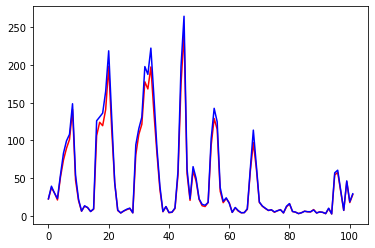

In [57]:
plt.plot(rmse_list_2x_context, color='red')
plt.plot(rmse_list, color='blue')

In [58]:
mape_list_2x_context = []
for act, prd_dt in zip(act_list_2x_context, prd_list_2x_context):
    mape_list_2x_context.append(mape(act, prd_dt['0.5'].tolist()))

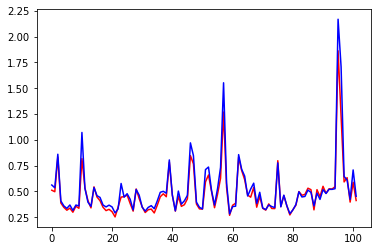

In [59]:
plt.plot(mape_list_2x_context, color='red')
plt.plot(mape_list[:102], color='blue')

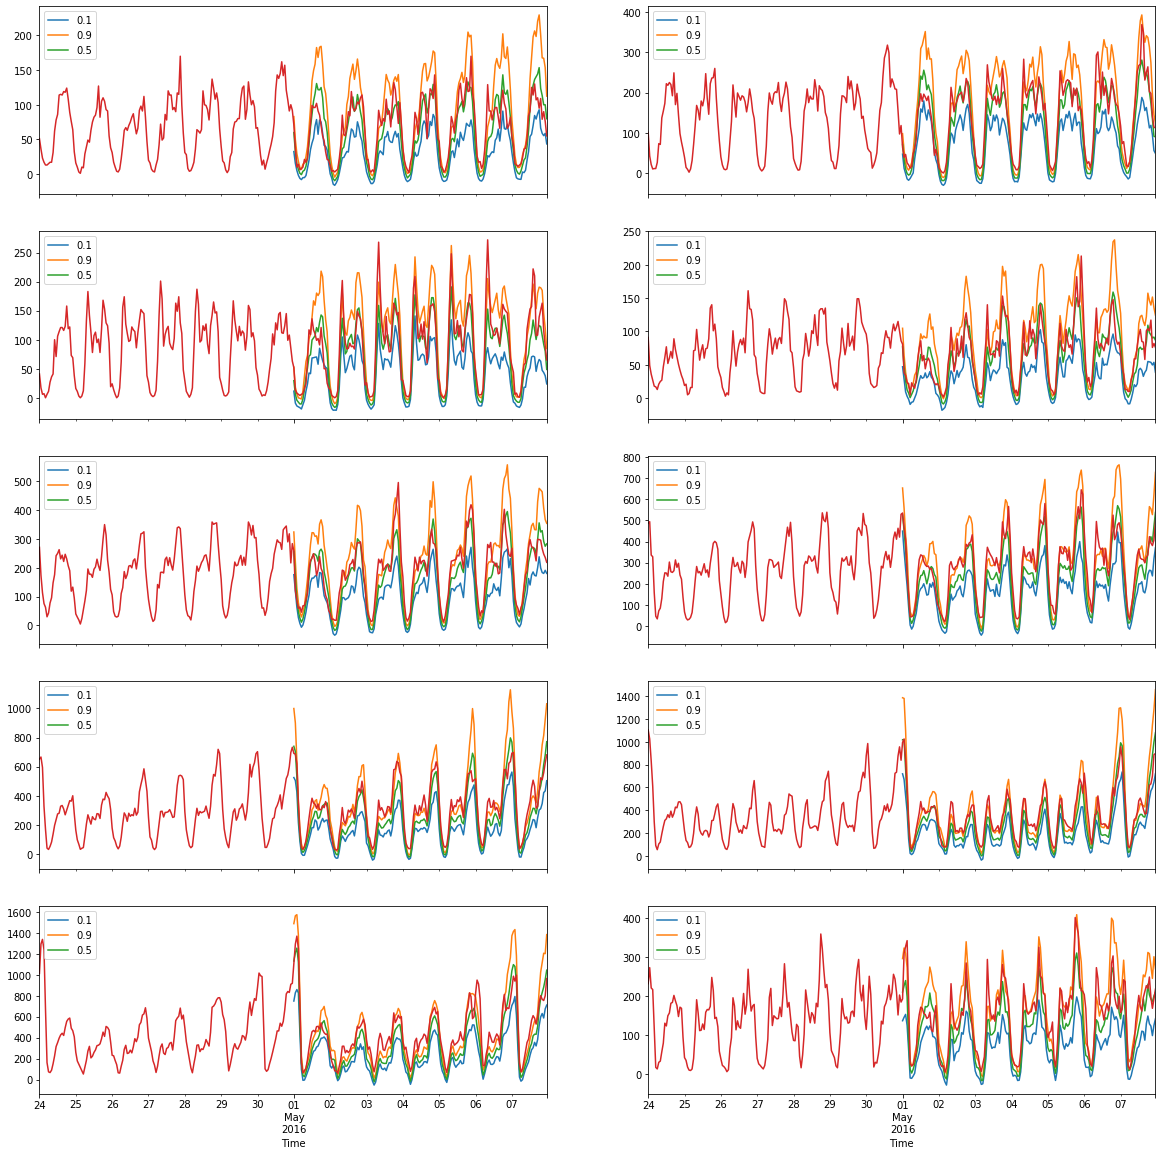

In [60]:
i = 0
start_dataset = pd.Timestamp("2016-04-24 00:00:00", freq=freq)

fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    ts = timeseries[i][start_dataset:start_predict+timedelta(hours=prediction_length)]
    prd = prd_list_2x_context[i]
    prd.plot(ax=axx[i])
    ts.plot(ax=axx[i])

In [61]:
predictor_2x_conext.delete_endpoint()

## Sagemaker: 3 layers in the network

In [62]:
name_for_modeling = 'deepar-YT-simple-3layers'
start_dataset = pd.Timestamp("2016-04-24 00:00:00", freq=freq)

In [63]:
estimator_3layers = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name=name_for_modeling,
    output_path=s3_output_path
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [64]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_layers":3
}

In [65]:
estimator_3layers.set_hyperparameters(**hyperparameters)

In [66]:
data_channels = {
    "train": "{}/train/train.json".format(s3_data_path),
    "test": "{}/test/test.json".format(s3_data_path)
}

estimator_3layers.fit(inputs=data_channels, wait=True)

2020-12-05 20:10:04 Starting - Starting the training job...
2020-12-05 20:10:06 Starting - Launching requested ML instances......
2020-12-05 20:11:33 Starting - Preparing the instances for training...
2020-12-05 20:12:17 Downloading - Downloading input data...
2020-12-05 20:12:53 Training - Training image download completed. Training in progress..Arguments: train
[12/05/2020 20:12:55 INFO 140557897897792] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u'

[12/05/2020 20:13:17 INFO 140557897897792] processed a total of 607 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 5470.862150192261, "sum": 5470.862150192261, "min": 5470.862150192261}}, "EndTime": 1607199197.167412, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607199191.696027}

[12/05/2020 20:13:17 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=110.948919594 records/second
[12/05/2020 20:13:17 INFO 140557897897792] #progress_metric: host=algo-1, completed 0 % of epochs
[12/05/2020 20:13:17 INFO 140557897897792] #quality_metric: host=algo-1, epoch=2, train loss <loss>=4.18559296131
[12/05/2020 20:13:17 INFO 140557897897792] best epoch loss so far
[12/05/2020 20:13:17 INFO 140557897897792] Saved checkpoint to "/opt/ml/model/state_a61d5534-95c7-4456-9c43-70b1205276ab-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"count": 1, "max": 147.43709564208984, "sum": 147.4370956420898

[12/05/2020 20:13:52 INFO 140557897897792] processed a total of 608 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 5437.12306022644, "sum": 5437.12306022644, "min": 5437.12306022644}}, "EndTime": 1607199232.248145, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607199226.810974}

[12/05/2020 20:13:52 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=111.821970733 records/second
[12/05/2020 20:13:52 INFO 140557897897792] #progress_metric: host=algo-1, completed 2 % of epochs
[12/05/2020 20:13:52 INFO 140557897897792] #quality_metric: host=algo-1, epoch=8, train loss <loss>=3.91218550205
[12/05/2020 20:13:52 INFO 140557897897792] loss did not improve
[12/05/2020 20:13:52 INFO 140557897897792] Epoch[9] Batch[0] avg_epoch_loss=4.092998
[12/05/2020 20:13:52 INFO 140557897897792] #quality_metric: host=algo-1, epoch=9, batch=0 train loss <loss>=4.09299755096
[12/05/2020 20:13:55 INFO 140557897897792]

[12/05/2020 20:14:27 INFO 140557897897792] Epoch[14] Batch[10] avg_epoch_loss=3.806270
[12/05/2020 20:14:27 INFO 140557897897792] #quality_metric: host=algo-1, epoch=14, batch=10 train loss <loss>=3.89332017899
[12/05/2020 20:14:27 INFO 140557897897792] Epoch[14] Batch [10]#011Speed: 121.43 samples/sec#011loss=3.893320
[12/05/2020 20:14:27 INFO 140557897897792] processed a total of 661 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 5974.848985671997, "sum": 5974.848985671997, "min": 5974.848985671997}}, "EndTime": 1607199267.441432, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607199261.466516}

[12/05/2020 20:14:27 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=110.627815474 records/second
[12/05/2020 20:14:27 INFO 140557897897792] #progress_metric: host=algo-1, completed 3 % of epochs
[12/05/2020 20:14:27 INFO 140557897897792] #quality_metric: host=algo-1, epoch=14, train loss <loss>=3.

[12/05/2020 20:15:08 INFO 140557897897792] Epoch[21] Batch[10] avg_epoch_loss=3.722226
[12/05/2020 20:15:08 INFO 140557897897792] #quality_metric: host=algo-1, epoch=21, batch=10 train loss <loss>=3.77632012367
[12/05/2020 20:15:08 INFO 140557897897792] Epoch[21] Batch [10]#011Speed: 120.38 samples/sec#011loss=3.776320
[12/05/2020 20:15:08 INFO 140557897897792] processed a total of 644 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6024.854898452759, "sum": 6024.854898452759, "min": 6024.854898452759}}, "EndTime": 1607199308.421937, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607199302.396653}

[12/05/2020 20:15:08 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=106.888146991 records/second
[12/05/2020 20:15:08 INFO 140557897897792] #progress_metric: host=algo-1, completed 5 % of epochs
[12/05/2020 20:15:08 INFO 140557897897792] #quality_metric: host=algo-1, epoch=21, train loss <loss>=3.

[12/05/2020 20:15:43 INFO 140557897897792] processed a total of 624 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 5506.684064865112, "sum": 5506.684064865112, "min": 5506.684064865112}}, "EndTime": 1607199343.044625, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607199337.53743}

[12/05/2020 20:15:43 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=113.314880631 records/second
[12/05/2020 20:15:43 INFO 140557897897792] #progress_metric: host=algo-1, completed 7 % of epochs
[12/05/2020 20:15:43 INFO 140557897897792] #quality_metric: host=algo-1, epoch=27, train loss <loss>=3.64151351452
[12/05/2020 20:15:43 INFO 140557897897792] loss did not improve
[12/05/2020 20:15:43 INFO 140557897897792] Epoch[28] Batch[0] avg_epoch_loss=3.771977
[12/05/2020 20:15:43 INFO 140557897897792] #quality_metric: host=algo-1, epoch=28, batch=0 train loss <loss>=3.77197694778
[12/05/2020 20:15:46 INFO 14055789789

[12/05/2020 20:16:17 INFO 140557897897792] processed a total of 624 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 5456.984996795654, "sum": 5456.984996795654, "min": 5456.984996795654}}, "EndTime": 1607199377.141172, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607199371.683716}

[12/05/2020 20:16:17 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=114.346909148 records/second
[12/05/2020 20:16:17 INFO 140557897897792] #progress_metric: host=algo-1, completed 8 % of epochs
[12/05/2020 20:16:17 INFO 140557897897792] #quality_metric: host=algo-1, epoch=33, train loss <loss>=3.61760723591
[12/05/2020 20:16:17 INFO 140557897897792] loss did not improve
[12/05/2020 20:16:17 INFO 140557897897792] Epoch[34] Batch[0] avg_epoch_loss=3.800605
[12/05/2020 20:16:17 INFO 140557897897792] #quality_metric: host=algo-1, epoch=34, batch=0 train loss <loss>=3.80060505867
[12/05/2020 20:16:20 INFO 1405578978

[12/05/2020 20:16:57 INFO 140557897897792] Epoch[40] Batch[10] avg_epoch_loss=3.846675
[12/05/2020 20:16:57 INFO 140557897897792] #quality_metric: host=algo-1, epoch=40, batch=10 train loss <loss>=4.04696154594
[12/05/2020 20:16:57 INFO 140557897897792] Epoch[40] Batch [10]#011Speed: 120.10 samples/sec#011loss=4.046962
[12/05/2020 20:16:57 INFO 140557897897792] processed a total of 642 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6014.368057250977, "sum": 6014.368057250977, "min": 6014.368057250977}}, "EndTime": 1607199417.301457, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607199411.286617}

[12/05/2020 20:16:57 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=106.741775224 records/second
[12/05/2020 20:16:57 INFO 140557897897792] #progress_metric: host=algo-1, completed 10 % of epochs
[12/05/2020 20:16:57 INFO 140557897897792] #quality_metric: host=algo-1, epoch=40, train loss <loss>=3

[12/05/2020 20:17:32 INFO 140557897897792] Epoch[46] Batch[10] avg_epoch_loss=3.467089
[12/05/2020 20:17:32 INFO 140557897897792] #quality_metric: host=algo-1, epoch=46, batch=10 train loss <loss>=3.30966472626
[12/05/2020 20:17:32 INFO 140557897897792] Epoch[46] Batch [10]#011Speed: 121.25 samples/sec#011loss=3.309665
[12/05/2020 20:17:32 INFO 140557897897792] processed a total of 659 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 5969.521999359131, "sum": 5969.521999359131, "min": 5969.521999359131}}, "EndTime": 1607199452.194007, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607199446.223884}

[12/05/2020 20:17:32 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=110.392176249 records/second
[12/05/2020 20:17:32 INFO 140557897897792] #progress_metric: host=algo-1, completed 11 % of epochs
[12/05/2020 20:17:32 INFO 140557897897792] #quality_metric: host=algo-1, epoch=46, train loss <loss>=3

[12/05/2020 20:18:06 INFO 140557897897792] processed a total of 596 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 5490.61393737793, "sum": 5490.61393737793, "min": 5490.61393737793}}, "EndTime": 1607199486.341112, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607199480.850019}

[12/05/2020 20:18:06 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=108.546665894 records/second
[12/05/2020 20:18:06 INFO 140557897897792] #progress_metric: host=algo-1, completed 13 % of epochs
[12/05/2020 20:18:06 INFO 140557897897792] #quality_metric: host=algo-1, epoch=52, train loss <loss>=3.45806305408
[12/05/2020 20:18:06 INFO 140557897897792] loss did not improve
[12/05/2020 20:18:07 INFO 140557897897792] Epoch[53] Batch[0] avg_epoch_loss=3.954635
[12/05/2020 20:18:07 INFO 140557897897792] #quality_metric: host=algo-1, epoch=53, batch=0 train loss <loss>=3.95463514328
[12/05/2020 20:18:09 INFO 140557897897

[12/05/2020 20:18:40 INFO 140557897897792] processed a total of 625 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 5466.65096282959, "sum": 5466.65096282959, "min": 5466.65096282959}}, "EndTime": 1607199520.717653, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607199515.250522}

[12/05/2020 20:18:40 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=114.326959036 records/second
[12/05/2020 20:18:40 INFO 140557897897792] #progress_metric: host=algo-1, completed 14 % of epochs
[12/05/2020 20:18:40 INFO 140557897897792] #quality_metric: host=algo-1, epoch=58, train loss <loss>=3.57668282986
[12/05/2020 20:18:40 INFO 140557897897792] loss did not improve
[12/05/2020 20:18:41 INFO 140557897897792] Epoch[59] Batch[0] avg_epoch_loss=3.223148
[12/05/2020 20:18:41 INFO 140557897897792] #quality_metric: host=algo-1, epoch=59, batch=0 train loss <loss>=3.22314810753
[12/05/2020 20:18:44 INFO 140557897897

[12/05/2020 20:19:16 INFO 140557897897792] processed a total of 609 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 5446.8560218811035, "sum": 5446.8560218811035, "min": 5446.8560218811035}}, "EndTime": 1607199556.188694, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607199550.741312}

[12/05/2020 20:19:16 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=111.805626648 records/second
[12/05/2020 20:19:16 INFO 140557897897792] #progress_metric: host=algo-1, completed 16 % of epochs
[12/05/2020 20:19:16 INFO 140557897897792] #quality_metric: host=algo-1, epoch=64, train loss <loss>=3.52024312019
[12/05/2020 20:19:16 INFO 140557897897792] loss did not improve
[12/05/2020 20:19:16 INFO 140557897897792] Epoch[65] Batch[0] avg_epoch_loss=3.641404
[12/05/2020 20:19:16 INFO 140557897897792] #quality_metric: host=algo-1, epoch=65, batch=0 train loss <loss>=3.64140367508
[12/05/2020 20:19:19 INFO 140557

[12/05/2020 20:19:56 INFO 140557897897792] processed a total of 634 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 5527.842044830322, "sum": 5527.842044830322, "min": 5527.842044830322}}, "EndTime": 1607199596.811208, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607199591.282834}

[12/05/2020 20:19:56 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=114.68952209 records/second
[12/05/2020 20:19:56 INFO 140557897897792] #progress_metric: host=algo-1, completed 18 % of epochs
[12/05/2020 20:19:56 INFO 140557897897792] #quality_metric: host=algo-1, epoch=71, train loss <loss>=3.46231667995
[12/05/2020 20:19:56 INFO 140557897897792] loss did not improve
[12/05/2020 20:19:57 INFO 140557897897792] Epoch[72] Batch[0] avg_epoch_loss=3.585227
[12/05/2020 20:19:57 INFO 140557897897792] #quality_metric: host=algo-1, epoch=72, batch=0 train loss <loss>=3.58522748947
[12/05/2020 20:20:00 INFO 1405578978

[12/05/2020 20:20:30 INFO 140557897897792] processed a total of 618 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 5483.723163604736, "sum": 5483.723163604736, "min": 5483.723163604736}}, "EndTime": 1607199630.905435, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607199625.421182}

[12/05/2020 20:20:30 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=112.694097733 records/second
[12/05/2020 20:20:30 INFO 140557897897792] #progress_metric: host=algo-1, completed 19 % of epochs
[12/05/2020 20:20:30 INFO 140557897897792] #quality_metric: host=algo-1, epoch=77, train loss <loss>=3.50305328369
[12/05/2020 20:20:30 INFO 140557897897792] loss did not improve
[12/05/2020 20:20:31 INFO 140557897897792] Epoch[78] Batch[0] avg_epoch_loss=3.419571
[12/05/2020 20:20:31 INFO 140557897897792] #quality_metric: host=algo-1, epoch=78, batch=0 train loss <loss>=3.41957139969
[12/05/2020 20:20:34 INFO 140557897

[12/05/2020 20:21:04 INFO 140557897897792] processed a total of 602 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 5477.96106338501, "sum": 5477.96106338501, "min": 5477.96106338501}}, "EndTime": 1607199664.184662, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607199658.706198}

[12/05/2020 20:21:04 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=109.891995079 records/second
[12/05/2020 20:21:04 INFO 140557897897792] #progress_metric: host=algo-1, completed 21 % of epochs
[12/05/2020 20:21:04 INFO 140557897897792] #quality_metric: host=algo-1, epoch=83, train loss <loss>=3.43454658985
[12/05/2020 20:21:04 INFO 140557897897792] best epoch loss so far
[12/05/2020 20:21:04 INFO 140557897897792] Saved checkpoint to "/opt/ml/model/state_c5588705-d921-44d7-ba41-111cb26c50a4-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"count": 1, "max": 169.96288299560547, "sum": 169.96288299560547

[12/05/2020 20:21:44 INFO 140557897897792] processed a total of 623 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 5493.947982788086, "sum": 5493.947982788086, "min": 5493.947982788086}}, "EndTime": 1607199704.664209, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607199699.169774}

[12/05/2020 20:21:44 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=113.394966907 records/second
[12/05/2020 20:21:44 INFO 140557897897792] #progress_metric: host=algo-1, completed 22 % of epochs
[12/05/2020 20:21:44 INFO 140557897897792] #quality_metric: host=algo-1, epoch=90, train loss <loss>=3.50796039104
[12/05/2020 20:21:44 INFO 140557897897792] loss did not improve
[12/05/2020 20:21:45 INFO 140557897897792] Epoch[91] Batch[0] avg_epoch_loss=3.547974
[12/05/2020 20:21:45 INFO 140557897897792] #quality_metric: host=algo-1, epoch=91, batch=0 train loss <loss>=3.54797363281
[12/05/2020 20:21:47 INFO 140557897

[12/05/2020 20:22:18 INFO 140557897897792] processed a total of 625 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 5441.587209701538, "sum": 5441.587209701538, "min": 5441.587209701538}}, "EndTime": 1607199738.580747, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607199733.139092}

[12/05/2020 20:22:18 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=114.853603103 records/second
[12/05/2020 20:22:18 INFO 140557897897792] #progress_metric: host=algo-1, completed 24 % of epochs
[12/05/2020 20:22:18 INFO 140557897897792] #quality_metric: host=algo-1, epoch=96, train loss <loss>=3.64283802509
[12/05/2020 20:22:18 INFO 140557897897792] loss did not improve
[12/05/2020 20:22:19 INFO 140557897897792] Epoch[97] Batch[0] avg_epoch_loss=3.681885
[12/05/2020 20:22:19 INFO 140557897897792] #quality_metric: host=algo-1, epoch=97, batch=0 train loss <loss>=3.68188548088
[12/05/2020 20:22:21 INFO 140557897

[12/05/2020 20:22:54 INFO 140557897897792] Epoch[102] Batch[10] avg_epoch_loss=3.448730
[12/05/2020 20:22:54 INFO 140557897897792] #quality_metric: host=algo-1, epoch=102, batch=10 train loss <loss>=3.43670315742
[12/05/2020 20:22:54 INFO 140557897897792] Epoch[102] Batch [10]#011Speed: 121.77 samples/sec#011loss=3.436703
[12/05/2020 20:22:54 INFO 140557897897792] processed a total of 652 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 5965.345859527588, "sum": 5965.345859527588, "min": 5965.345859527588}}, "EndTime": 1607199774.744442, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607199768.778567}

[12/05/2020 20:22:54 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=109.295771027 records/second
[12/05/2020 20:22:54 INFO 140557897897792] #progress_metric: host=algo-1, completed 25 % of epochs
[12/05/2020 20:22:54 INFO 140557897897792] #quality_metric: host=algo-1, epoch=102, train loss <los

[12/05/2020 20:23:34 INFO 140557897897792] processed a total of 638 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 5497.5950717926025, "sum": 5497.5950717926025, "min": 5497.5950717926025}}, "EndTime": 1607199814.99979, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607199809.501734}

[12/05/2020 20:23:34 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=116.048695971 records/second
[12/05/2020 20:23:35 INFO 140557897897792] #progress_metric: host=algo-1, completed 27 % of epochs
[12/05/2020 20:23:35 INFO 140557897897792] #quality_metric: host=algo-1, epoch=109, train loss <loss>=3.4839505434
[12/05/2020 20:23:35 INFO 140557897897792] loss did not improve
[12/05/2020 20:23:35 INFO 140557897897792] Epoch[110] Batch[0] avg_epoch_loss=3.446578
[12/05/2020 20:23:35 INFO 140557897897792] #quality_metric: host=algo-1, epoch=110, batch=0 train loss <loss>=3.44657754898
[12/05/2020 20:23:38 INFO 14055

[12/05/2020 20:24:09 INFO 140557897897792] processed a total of 633 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 5525.132894515991, "sum": 5525.132894515991, "min": 5525.132894515991}}, "EndTime": 1607199849.130097, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607199843.604464}

[12/05/2020 20:24:09 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=114.564769771 records/second
[12/05/2020 20:24:09 INFO 140557897897792] #progress_metric: host=algo-1, completed 29 % of epochs
[12/05/2020 20:24:09 INFO 140557897897792] #quality_metric: host=algo-1, epoch=115, train loss <loss>=3.46390914917
[12/05/2020 20:24:09 INFO 140557897897792] loss did not improve
[12/05/2020 20:24:09 INFO 140557897897792] Epoch[116] Batch[0] avg_epoch_loss=3.388031
[12/05/2020 20:24:09 INFO 140557897897792] #quality_metric: host=algo-1, epoch=116, batch=0 train loss <loss>=3.38803076744
[12/05/2020 20:24:12 INFO 140557

[12/05/2020 20:24:43 INFO 140557897897792] processed a total of 633 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 5543.888092041016, "sum": 5543.888092041016, "min": 5543.888092041016}}, "EndTime": 1607199883.250571, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607199877.706206}

[12/05/2020 20:24:43 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=114.177279886 records/second
[12/05/2020 20:24:43 INFO 140557897897792] #progress_metric: host=algo-1, completed 30 % of epochs
[12/05/2020 20:24:43 INFO 140557897897792] #quality_metric: host=algo-1, epoch=121, train loss <loss>=3.43380272388
[12/05/2020 20:24:43 INFO 140557897897792] loss did not improve
[12/05/2020 20:24:44 INFO 140557897897792] Epoch[122] Batch[0] avg_epoch_loss=3.438399
[12/05/2020 20:24:44 INFO 140557897897792] #quality_metric: host=algo-1, epoch=122, batch=0 train loss <loss>=3.43839931488
[12/05/2020 20:24:46 INFO 140557

[12/05/2020 20:25:22 INFO 140557897897792] Epoch[128] Batch[10] avg_epoch_loss=3.353940
[12/05/2020 20:25:22 INFO 140557897897792] #quality_metric: host=algo-1, epoch=128, batch=10 train loss <loss>=3.20124588013
[12/05/2020 20:25:22 INFO 140557897897792] Epoch[128] Batch [10]#011Speed: 121.46 samples/sec#011loss=3.201246
[12/05/2020 20:25:22 INFO 140557897897792] processed a total of 641 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 5963.706970214844, "sum": 5963.706970214844, "min": 5963.706970214844}}, "EndTime": 1607199922.688346, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607199916.724133}

[12/05/2020 20:25:22 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=107.48124915 records/second
[12/05/2020 20:25:22 INFO 140557897897792] #progress_metric: host=algo-1, completed 32 % of epochs
[12/05/2020 20:25:22 INFO 140557897897792] #quality_metric: host=algo-1, epoch=128, train loss <loss

[12/05/2020 20:25:57 INFO 140557897897792] processed a total of 581 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 5414.657831192017, "sum": 5414.657831192017, "min": 5414.657831192017}}, "EndTime": 1607199957.011328, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607199951.596231}

[12/05/2020 20:25:57 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=107.298894552 records/second
[12/05/2020 20:25:57 INFO 140557897897792] #progress_metric: host=algo-1, completed 33 % of epochs
[12/05/2020 20:25:57 INFO 140557897897792] #quality_metric: host=algo-1, epoch=134, train loss <loss>=3.25511842966
[12/05/2020 20:25:57 INFO 140557897897792] best epoch loss so far
[12/05/2020 20:25:57 INFO 140557897897792] Saved checkpoint to "/opt/ml/model/state_32dcf05e-2455-4c2b-8b6f-6832a6afc005-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"count": 1, "max": 159.21998023986816, "sum": 159.2199802398

[12/05/2020 20:26:32 INFO 140557897897792] Epoch[140] Batch[10] avg_epoch_loss=3.515702
[12/05/2020 20:26:32 INFO 140557897897792] #quality_metric: host=algo-1, epoch=140, batch=10 train loss <loss>=3.54614162445
[12/05/2020 20:26:32 INFO 140557897897792] Epoch[140] Batch [10]#011Speed: 120.16 samples/sec#011loss=3.546142
[12/05/2020 20:26:32 INFO 140557897897792] processed a total of 679 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6058.246850967407, "sum": 6058.246850967407, "min": 6058.246850967407}}, "EndTime": 1607199992.727735, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607199986.669013}

[12/05/2020 20:26:32 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=112.07647638 records/second
[12/05/2020 20:26:32 INFO 140557897897792] #progress_metric: host=algo-1, completed 35 % of epochs
[12/05/2020 20:26:32 INFO 140557897897792] #quality_metric: host=algo-1, epoch=140, train loss <loss

[12/05/2020 20:27:07 INFO 140557897897792] Epoch[146] Batch[10] avg_epoch_loss=3.473437
[12/05/2020 20:27:07 INFO 140557897897792] #quality_metric: host=algo-1, epoch=146, batch=10 train loss <loss>=3.55754261017
[12/05/2020 20:27:07 INFO 140557897897792] Epoch[146] Batch [10]#011Speed: 120.96 samples/sec#011loss=3.557543
[12/05/2020 20:27:07 INFO 140557897897792] processed a total of 671 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6070.378065109253, "sum": 6070.378065109253, "min": 6070.378065109253}}, "EndTime": 1607200027.233838, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607200021.162952}

[12/05/2020 20:27:07 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=110.534645385 records/second
[12/05/2020 20:27:07 INFO 140557897897792] #progress_metric: host=algo-1, completed 36 % of epochs
[12/05/2020 20:27:07 INFO 140557897897792] #quality_metric: host=algo-1, epoch=146, train loss <los

[12/05/2020 20:27:42 INFO 140557897897792] Epoch[152] Batch[10] avg_epoch_loss=3.401994
[12/05/2020 20:27:42 INFO 140557897897792] #quality_metric: host=algo-1, epoch=152, batch=10 train loss <loss>=3.3236243248
[12/05/2020 20:27:42 INFO 140557897897792] Epoch[152] Batch [10]#011Speed: 120.30 samples/sec#011loss=3.323624
[12/05/2020 20:27:42 INFO 140557897897792] processed a total of 650 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6011.042833328247, "sum": 6011.042833328247, "min": 6011.042833328247}}, "EndTime": 1607200062.268228, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607200056.256691}

[12/05/2020 20:27:42 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=108.131720361 records/second
[12/05/2020 20:27:42 INFO 140557897897792] #progress_metric: host=algo-1, completed 38 % of epochs
[12/05/2020 20:27:42 INFO 140557897897792] #quality_metric: host=algo-1, epoch=152, train loss <loss

[12/05/2020 20:28:23 INFO 140557897897792] processed a total of 615 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 5535.620927810669, "sum": 5535.620927810669, "min": 5535.620927810669}}, "EndTime": 1607200103.330834, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607200097.794748}

[12/05/2020 20:28:23 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=111.096398926 records/second
[12/05/2020 20:28:23 INFO 140557897897792] #progress_metric: host=algo-1, completed 40 % of epochs
[12/05/2020 20:28:23 INFO 140557897897792] #quality_metric: host=algo-1, epoch=159, train loss <loss>=3.47687511444
[12/05/2020 20:28:23 INFO 140557897897792] loss did not improve
[12/05/2020 20:28:24 INFO 140557897897792] Epoch[160] Batch[0] avg_epoch_loss=3.657103
[12/05/2020 20:28:24 INFO 140557897897792] #quality_metric: host=algo-1, epoch=160, batch=0 train loss <loss>=3.65710330009
[12/05/2020 20:28:26 INFO 140557

[12/05/2020 20:28:57 INFO 140557897897792] processed a total of 566 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 5002.018928527832, "sum": 5002.018928527832, "min": 5002.018928527832}}, "EndTime": 1607200137.941069, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607200132.938606}

[12/05/2020 20:28:57 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=113.151462242 records/second
[12/05/2020 20:28:57 INFO 140557897897792] #progress_metric: host=algo-1, completed 41 % of epochs
[12/05/2020 20:28:57 INFO 140557897897792] #quality_metric: host=algo-1, epoch=165, train loss <loss>=3.42547978295
[12/05/2020 20:28:57 INFO 140557897897792] loss did not improve
[12/05/2020 20:28:58 INFO 140557897897792] Epoch[166] Batch[0] avg_epoch_loss=3.348709
[12/05/2020 20:28:58 INFO 140557897897792] #quality_metric: host=algo-1, epoch=166, batch=0 train loss <loss>=3.34870862961
[12/05/2020 20:29:01 INFO 140557

[12/05/2020 20:29:33 INFO 140557897897792] processed a total of 608 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 5514.184951782227, "sum": 5514.184951782227, "min": 5514.184951782227}}, "EndTime": 1607200173.058397, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607200167.543718}

[12/05/2020 20:29:33 INFO 140557897897792] #throughput_metric: host=algo-1, train throughput=110.258860597 records/second
[12/05/2020 20:29:33 INFO 140557897897792] #progress_metric: host=algo-1, completed 43 % of epochs
[12/05/2020 20:29:33 INFO 140557897897792] #quality_metric: host=algo-1, epoch=171, train loss <loss>=3.49626791477
[12/05/2020 20:29:33 INFO 140557897897792] loss did not improve
[12/05/2020 20:29:33 INFO 140557897897792] Epoch[172] Batch[0] avg_epoch_loss=3.253607
[12/05/2020 20:29:33 INFO 140557897897792] #quality_metric: host=algo-1, epoch=172, batch=0 train loss <loss>=3.25360679626
[12/05/2020 20:29:36 INFO 140557


2020-12-05 20:30:59 Uploading - Uploading generated training model#metrics {"Metrics": {"model.score.time": {"count": 1, "max": 63513.77606391907, "sum": 63513.77606391907, "min": 63513.77606391907}}, "EndTime": 1607200256.73352, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607200193.219815}

[12/05/2020 20:30:56 INFO 140557897897792] #test_score (algo-1, RMSE): 49.8948618374
[12/05/2020 20:30:56 INFO 140557897897792] #test_score (algo-1, mean_absolute_QuantileLoss): 1362554.1965505874
[12/05/2020 20:30:56 INFO 140557897897792] #test_score (algo-1, mean_wQuantileLoss): 0.12950566224238305
[12/05/2020 20:30:56 INFO 140557897897792] #test_score (algo-1, wQuantileLoss[0.1]): 0.09756094079544587
[12/05/2020 20:30:56 INFO 140557897897792] #test_score (algo-1, wQuantileLoss[0.2]): 0.13233186913074937
[12/05/2020 20:30:56 INFO 140557897897792] #test_score (algo-1, wQuantileLoss[0.3]): 0.1512086901217276
[12/05/2020 20:30:56 INFO 14055789

In [67]:
predictor_3layers = estimator_3layers.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    predictor_cls=DeepARPredictor)

-------------!

In [69]:
rmse_list_3layers = []
prd_list_3layers = []
act_list_3layers = []
for ts in timeseries:
    prd_dt = predictor_3layers.predict(ts=ts[:start_predict], quantiles=[0.1,0.5, 0.9])
    prd = prd_dt['0.5'].tolist()
    act = ts[start_predict + timedelta(hours=1):start_predict+timedelta(hours=prediction_length)].tolist()
    rmse_list_3layers.append(sqrt(mean_squared_error(act, prd)))
    prd_list_3layers.append(prd_dt)
    act_list_3layers.append(act)

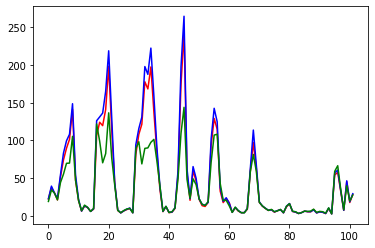

In [70]:
plt.plot(rmse_list_2x_context, color='red')
plt.plot(rmse_list, color='blue')
plt.plot(rmse_list_3layers, color='green')

In [71]:
mape_list_3layers= []
for act, prd_dt in zip(act_list_3layers, prd_list_3layers):
    mape_list_3layers.append(mape(act, prd_dt['0.5'].tolist()))

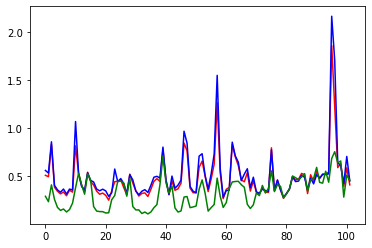

In [72]:
plt.plot(mape_list_2x_context, color='red')
plt.plot(mape_list[:102], color='blue')
plt.plot(mape_list_3layers, color='green')

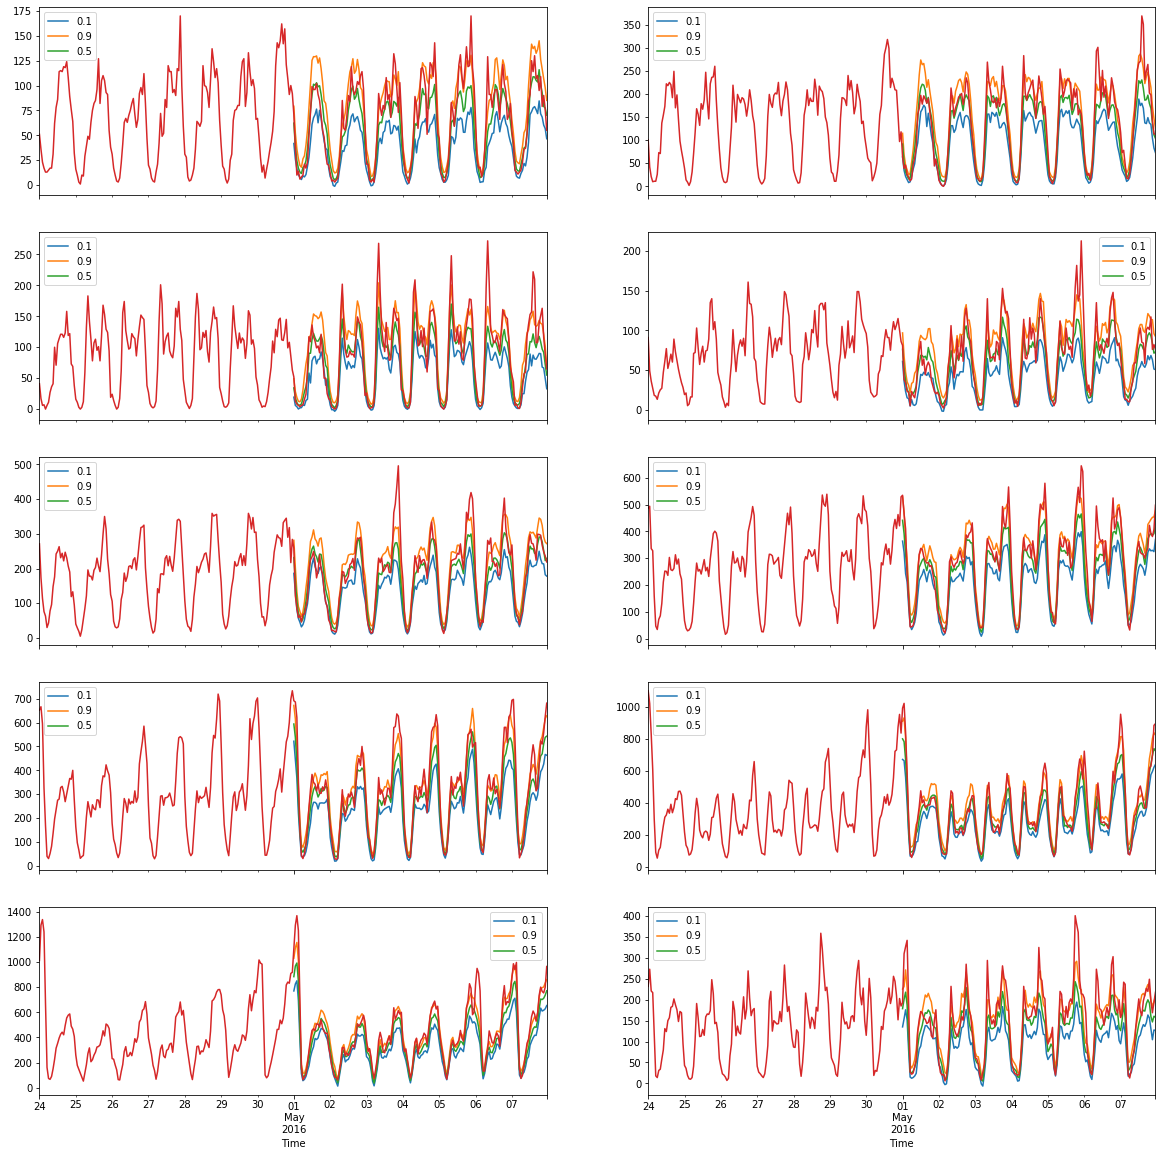

In [73]:
i = 0
start_dataset = pd.Timestamp("2016-04-24 00:00:00", freq=freq)

fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    ts = timeseries[i][start_dataset:start_predict+timedelta(hours=prediction_length)]
    prd = prd_list_3layers[i]
    prd.plot(ax=axx[i])
    ts.plot(ax=axx[i])

In [74]:
predictor_3layers.delete_endpoint()

## Sagemaker with clusters as additional feature

In [75]:
clusters_data = pd.read_csv(os.path.join(supporting_dp, 'clusters.csv'), header=0)
print(clusters_data.shape)
clusters_data.head()

(102, 3)


euc_dist  labels  square_id
0   714.069342       1       1075
1  2540.654637       1       1076
2   750.950385       1       1077
3   434.397957       1       1125
4  2633.580787       5       1126

In [76]:
cat_list = [clusters_data.loc[clusters_data.square_id == int(x)].labels.tolist()[0] for x in pivoted_dt.columns]

In [77]:
start_dataset = pd.Timestamp("2016-04-01 00:00:00", freq=freq)

In [78]:
training_data_with_cluster = [
    {
        "start": str(start_dataset),
        # We use -1, because pandas indexing includes the upper bound
        "target": ts[start_dataset:end_training - timedelta(hours=25)].tolist(),   
        'cat': [cat_list[i]]
    }
    for i,ts in enumerate(timeseries)
]
print(len(training_data_with_cluster))

102


In [79]:
training_data_with_cluster[0]

{'start': '2016-04-01 00:00:00',
 'target': [46.0,
  25.0,
  12.0,
  8.0,
  9.0,
  7.0,
  16.0,
  43.0,
  70.0,
  59.0,
  72.0,
  86.0,
  110.0,
  104.0,
  93.0,
  111.0,
  83.0,
  110.0,
  133.0,
  116.0,
  80.0,
  85.0,
  92.0,
  107.0,
  49.0,
  29.0,
  29.0,
  10.0,
  5.0,
  4.0,
  15.0,
  20.0,
  30.0,
  36.0,
  77.0,
  77.0,
  85.0,
  123.0,
  109.0,
  135.0,
  121.0,
  119.0,
  102.0,
  100.0,
  69.0,
  71.0,
  62.0,
  62.0,
  58.0,
  26.0,
  30.0,
  17.0,
  10.0,
  7.0,
  10.0,
  13.0,
  24.0,
  62.0,
  76.0,
  90.0,
  101.0,
  69.0,
  76.0,
  53.0,
  56.0,
  55.0,
  57.0,
  46.0,
  42.0,
  35.0,
  34.0,
  12.0,
  16.0,
  5.0,
  3.0,
  2.0,
  4.0,
  11.0,
  19.0,
  44.0,
  76.0,
  80.0,
  71.0,
  71.0,
  75.0,
  88.0,
  125.0,
  105.0,
  68.0,
  72.0,
  99.0,
  82.0,
  97.0,
  85.0,
  46.0,
  33.0,
  22.0,
  10.0,
  1.0,
  3.0,
  1.0,
  10.0,
  26.0,
  40.0,
  86.0,
  99.0,
  82.0,
  105.0,
  108.0,
  113.0,
  121.0,
  108.0,
  77.0,
  76.0,
  86.0,
  108.0,
  120.0,
  100.0,
 

In [80]:
num_test_windows = 4

test_data_data_with_cluster = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training + timedelta(hours=k * prediction_length-k)].tolist(),
        'cat': [cat_list[i]]
    }
    for k in range(1, num_test_windows + 1) 
    for i,ts in enumerate(timeseries)
]
print(len(test_data_data_with_cluster))

408


In [81]:
write_dicts_to_file(os.path.join(output_data_path,"train-with-clusters.json"), training_data_with_cluster)
write_dicts_to_file(os.path.join(output_data_path,"test-with-clusters.json"), test_data_data_with_cluster)

In [82]:
copy_to_s3(os.path.join(output_data_path,"train-with-clusters.json"), s3_data_path + "/train/train-with-clusters.json"
           , override=True)
copy_to_s3(os.path.join(output_data_path,"test-with-clusters.json"), s3_data_path + "/test/test-with-clusters.json"
           , override=True)

Overwriting existing file
Uploading file to s3://sagemaker-us-west-2-676236127588/deepar-YT-simple-notebook/data/train/train-with-clusters.json
Overwriting existing file
Uploading file to s3://sagemaker-us-west-2-676236127588/deepar-YT-simple-notebook/data/test/test-with-clusters.json


In [83]:
name_for_modeling = 'deepar-YT-simple-with-clusters'

In [84]:
estimator_with_clusters = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name=name_for_modeling,
    output_path=s3_output_path
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [85]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "cardinality": str(7)
}

In [86]:
estimator_with_clusters.set_hyperparameters(**hyperparameters)

In [87]:
data_channels = {
    "train": "{}/train/train-with-clusters.json".format(s3_data_path),
    "test": "{}/test/test-with-clusters.json".format(s3_data_path)
}

estimator_with_clusters.fit(inputs=data_channels, wait=True)

2020-12-05 20:41:52 Starting - Starting the training job...
2020-12-05 20:41:54 Starting - Launching requested ML instances......
2020-12-05 20:43:03 Starting - Preparing the instances for training...
2020-12-05 20:43:53 Downloading - Downloading input data...
2020-12-05 20:44:35 Training - Training image download completed. Training in progress.Arguments: train
[12/05/2020 20:44:39 INFO 140309187159872] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''

[12/05/2020 20:45:07 INFO 140309187159872] Epoch[5] Batch[0] avg_epoch_loss=3.931550
[12/05/2020 20:45:07 INFO 140309187159872] #quality_metric: host=algo-1, epoch=5, batch=0 train loss <loss>=3.93155002594
[12/05/2020 20:45:09 INFO 140309187159872] Epoch[5] Batch[5] avg_epoch_loss=4.118595
[12/05/2020 20:45:09 INFO 140309187159872] #quality_metric: host=algo-1, epoch=5, batch=5 train loss <loss>=4.11859528224
[12/05/2020 20:45:09 INFO 140309187159872] Epoch[5] Batch [5]#011Speed: 158.16 samples/sec#011loss=4.118595
[12/05/2020 20:45:11 INFO 140309187159872] processed a total of 638 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4377.1820068359375, "sum": 4377.1820068359375, "min": 4377.1820068359375}}, "EndTime": 1607201111.642957, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607201107.265699}

[12/05/2020 20:45:11 INFO 140309187159872] #throughput_metric: host=algo-1, train throughput=145.750549554 records/seco

[12/05/2020 20:45:30 INFO 140309187159872] Epoch[10] Batch[0] avg_epoch_loss=3.777854
[12/05/2020 20:45:30 INFO 140309187159872] #quality_metric: host=algo-1, epoch=10, batch=0 train loss <loss>=3.77785420418
[12/05/2020 20:45:32 INFO 140309187159872] Epoch[10] Batch[5] avg_epoch_loss=3.894662
[12/05/2020 20:45:32 INFO 140309187159872] #quality_metric: host=algo-1, epoch=10, batch=5 train loss <loss>=3.89466238022
[12/05/2020 20:45:32 INFO 140309187159872] Epoch[10] Batch [5]#011Speed: 156.68 samples/sec#011loss=3.894662
[12/05/2020 20:45:34 INFO 140309187159872] processed a total of 628 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4341.067790985107, "sum": 4341.067790985107, "min": 4341.067790985107}}, "EndTime": 1607201134.591212, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607201130.250064}

[12/05/2020 20:45:34 INFO 140309187159872] #throughput_metric: host=algo-1, train throughput=144.659831137 records/se

[12/05/2020 20:46:07 INFO 140309187159872] Epoch[18] Batch[0] avg_epoch_loss=3.819816
[12/05/2020 20:46:07 INFO 140309187159872] #quality_metric: host=algo-1, epoch=18, batch=0 train loss <loss>=3.81981635094
[12/05/2020 20:46:09 INFO 140309187159872] Epoch[18] Batch[5] avg_epoch_loss=3.765277
[12/05/2020 20:46:09 INFO 140309187159872] #quality_metric: host=algo-1, epoch=18, batch=5 train loss <loss>=3.76527674993
[12/05/2020 20:46:09 INFO 140309187159872] Epoch[18] Batch [5]#011Speed: 157.37 samples/sec#011loss=3.765277
[12/05/2020 20:46:11 INFO 140309187159872] processed a total of 591 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4312.3509883880615, "sum": 4312.3509883880615, "min": 4312.3509883880615}}, "EndTime": 1607201171.338575, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607201167.026131}

[12/05/2020 20:46:11 INFO 140309187159872] #throughput_metric: host=algo-1, train throughput=137.043387343 records

[12/05/2020 20:46:41 INFO 140309187159872] Epoch[25] Batch[5] avg_epoch_loss=3.717129
[12/05/2020 20:46:41 INFO 140309187159872] #quality_metric: host=algo-1, epoch=25, batch=5 train loss <loss>=3.71712859472
[12/05/2020 20:46:41 INFO 140309187159872] Epoch[25] Batch [5]#011Speed: 156.46 samples/sec#011loss=3.717129
[12/05/2020 20:46:43 INFO 140309187159872] Epoch[25] Batch[10] avg_epoch_loss=3.616684
[12/05/2020 20:46:43 INFO 140309187159872] #quality_metric: host=algo-1, epoch=25, batch=10 train loss <loss>=3.49615116119
[12/05/2020 20:46:43 INFO 140309187159872] Epoch[25] Batch [10]#011Speed: 153.74 samples/sec#011loss=3.496151
[12/05/2020 20:46:43 INFO 140309187159872] processed a total of 664 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4803.540945053101, "sum": 4803.540945053101, "min": 4803.540945053101}}, "EndTime": 1607201203.346726, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607201198.542659}

[12/0

[12/05/2020 20:47:09 INFO 140309187159872] Epoch[31] Batch[5] avg_epoch_loss=3.623870
[12/05/2020 20:47:09 INFO 140309187159872] #quality_metric: host=algo-1, epoch=31, batch=5 train loss <loss>=3.6238698562
[12/05/2020 20:47:09 INFO 140309187159872] Epoch[31] Batch [5]#011Speed: 156.18 samples/sec#011loss=3.623870
[12/05/2020 20:47:11 INFO 140309187159872] Epoch[31] Batch[10] avg_epoch_loss=3.642052
[12/05/2020 20:47:11 INFO 140309187159872] #quality_metric: host=algo-1, epoch=31, batch=10 train loss <loss>=3.66387081146
[12/05/2020 20:47:11 INFO 140309187159872] Epoch[31] Batch [10]#011Speed: 154.39 samples/sec#011loss=3.663871
[12/05/2020 20:47:11 INFO 140309187159872] processed a total of 691 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4821.353197097778, "sum": 4821.353197097778, "min": 4821.353197097778}}, "EndTime": 1607201231.704424, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607201226.882585}

[12/05

[12/05/2020 20:47:46 INFO 140309187159872] Epoch[39] Batch[5] avg_epoch_loss=3.666961
[12/05/2020 20:47:46 INFO 140309187159872] #quality_metric: host=algo-1, epoch=39, batch=5 train loss <loss>=3.66696075598
[12/05/2020 20:47:46 INFO 140309187159872] Epoch[39] Batch [5]#011Speed: 156.77 samples/sec#011loss=3.666961
[12/05/2020 20:47:47 INFO 140309187159872] processed a total of 597 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4324.14698600769, "sum": 4324.14698600769, "min": 4324.14698600769}}, "EndTime": 1607201267.759391, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607201263.434694}

[12/05/2020 20:47:47 INFO 140309187159872] #throughput_metric: host=algo-1, train throughput=138.057474044 records/second
[12/05/2020 20:47:47 INFO 140309187159872] #progress_metric: host=algo-1, completed 10 % of epochs
[12/05/2020 20:47:47 INFO 140309187159872] #quality_metric: host=algo-1, epoch=39, train loss <loss>=3.64381

[12/05/2020 20:48:18 INFO 140309187159872] Epoch[46] Batch[5] avg_epoch_loss=3.589820
[12/05/2020 20:48:18 INFO 140309187159872] #quality_metric: host=algo-1, epoch=46, batch=5 train loss <loss>=3.58982038498
[12/05/2020 20:48:18 INFO 140309187159872] Epoch[46] Batch [5]#011Speed: 156.90 samples/sec#011loss=3.589820
[12/05/2020 20:48:20 INFO 140309187159872] Epoch[46] Batch[10] avg_epoch_loss=3.575054
[12/05/2020 20:48:20 INFO 140309187159872] #quality_metric: host=algo-1, epoch=46, batch=10 train loss <loss>=3.55733366013
[12/05/2020 20:48:20 INFO 140309187159872] Epoch[46] Batch [10]#011Speed: 153.09 samples/sec#011loss=3.557334
[12/05/2020 20:48:20 INFO 140309187159872] processed a total of 663 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4761.780023574829, "sum": 4761.780023574829, "min": 4761.780023574829}}, "EndTime": 1607201300.770441, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607201296.008586}

[12/0

[12/05/2020 20:48:44 INFO 140309187159872] Epoch[51] Batch[10] avg_epoch_loss=3.605832
[12/05/2020 20:48:44 INFO 140309187159872] #quality_metric: host=algo-1, epoch=51, batch=10 train loss <loss>=3.61047029495
[12/05/2020 20:48:44 INFO 140309187159872] Epoch[51] Batch [10]#011Speed: 154.85 samples/sec#011loss=3.610470
[12/05/2020 20:48:44 INFO 140309187159872] processed a total of 653 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4756.892919540405, "sum": 4756.892919540405, "min": 4756.892919540405}}, "EndTime": 1607201324.619617, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607201319.862255}

[12/05/2020 20:48:44 INFO 140309187159872] #throughput_metric: host=algo-1, train throughput=137.270702418 records/second
[12/05/2020 20:48:44 INFO 140309187159872] #progress_metric: host=algo-1, completed 13 % of epochs
[12/05/2020 20:48:44 INFO 140309187159872] #quality_metric: host=algo-1, epoch=51, train loss <loss>=3

[12/05/2020 20:49:21 INFO 140309187159872] Epoch[59] Batch[10] avg_epoch_loss=3.484721
[12/05/2020 20:49:21 INFO 140309187159872] #quality_metric: host=algo-1, epoch=59, batch=10 train loss <loss>=3.44676728249
[12/05/2020 20:49:21 INFO 140309187159872] Epoch[59] Batch [10]#011Speed: 150.94 samples/sec#011loss=3.446767
[12/05/2020 20:49:21 INFO 140309187159872] processed a total of 675 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4810.630083084106, "sum": 4810.630083084106, "min": 4810.630083084106}}, "EndTime": 1607201361.741057, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607201356.929887}

[12/05/2020 20:49:21 INFO 140309187159872] #throughput_metric: host=algo-1, train throughput=140.310233651 records/second
[12/05/2020 20:49:21 INFO 140309187159872] #progress_metric: host=algo-1, completed 15 % of epochs
[12/05/2020 20:49:21 INFO 140309187159872] #quality_metric: host=algo-1, epoch=59, train loss <loss>=3

[12/05/2020 20:49:46 INFO 140309187159872] Epoch[65] Batch[5] avg_epoch_loss=3.528068
[12/05/2020 20:49:46 INFO 140309187159872] #quality_metric: host=algo-1, epoch=65, batch=5 train loss <loss>=3.52806846301
[12/05/2020 20:49:46 INFO 140309187159872] Epoch[65] Batch [5]#011Speed: 156.13 samples/sec#011loss=3.528068
[12/05/2020 20:49:48 INFO 140309187159872] Epoch[65] Batch[10] avg_epoch_loss=3.614556
[12/05/2020 20:49:48 INFO 140309187159872] #quality_metric: host=algo-1, epoch=65, batch=10 train loss <loss>=3.71834154129
[12/05/2020 20:49:48 INFO 140309187159872] Epoch[65] Batch [10]#011Speed: 155.06 samples/sec#011loss=3.718342
[12/05/2020 20:49:48 INFO 140309187159872] processed a total of 701 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4830.851078033447, "sum": 4830.851078033447, "min": 4830.851078033447}}, "EndTime": 1607201388.703111, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607201383.871757}

[12/0

[12/05/2020 20:50:22 INFO 140309187159872] Epoch[73] Batch[0] avg_epoch_loss=3.482787
[12/05/2020 20:50:22 INFO 140309187159872] #quality_metric: host=algo-1, epoch=73, batch=0 train loss <loss>=3.48278737068
[12/05/2020 20:50:24 INFO 140309187159872] Epoch[73] Batch[5] avg_epoch_loss=3.512660
[12/05/2020 20:50:24 INFO 140309187159872] #quality_metric: host=algo-1, epoch=73, batch=5 train loss <loss>=3.51265950998
[12/05/2020 20:50:24 INFO 140309187159872] Epoch[73] Batch [5]#011Speed: 153.78 samples/sec#011loss=3.512660
[12/05/2020 20:50:26 INFO 140309187159872] Epoch[73] Batch[10] avg_epoch_loss=3.574058
[12/05/2020 20:50:26 INFO 140309187159872] #quality_metric: host=algo-1, epoch=73, batch=10 train loss <loss>=3.64773626328
[12/05/2020 20:50:26 INFO 140309187159872] Epoch[73] Batch [10]#011Speed: 148.11 samples/sec#011loss=3.647736
[12/05/2020 20:50:26 INFO 140309187159872] processed a total of 659 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4875.662088394165,

[12/05/2020 20:50:49 INFO 140309187159872] Epoch[78] Batch[10] avg_epoch_loss=3.557411
[12/05/2020 20:50:49 INFO 140309187159872] #quality_metric: host=algo-1, epoch=78, batch=10 train loss <loss>=3.46644830704
[12/05/2020 20:50:49 INFO 140309187159872] Epoch[78] Batch [10]#011Speed: 154.24 samples/sec#011loss=3.466448
[12/05/2020 20:50:49 INFO 140309187159872] processed a total of 666 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4809.030055999756, "sum": 4809.030055999756, "min": 4809.030055999756}}, "EndTime": 1607201449.802879, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607201444.993337}

[12/05/2020 20:50:49 INFO 140309187159872] #throughput_metric: host=algo-1, train throughput=138.485867425 records/second
[12/05/2020 20:50:49 INFO 140309187159872] #progress_metric: host=algo-1, completed 19 % of epochs
[12/05/2020 20:50:49 INFO 140309187159872] #quality_metric: host=algo-1, epoch=78, train loss <loss>=3

[12/05/2020 20:51:21 INFO 140309187159872] Epoch[86] Batch[0] avg_epoch_loss=3.837240
[12/05/2020 20:51:21 INFO 140309187159872] #quality_metric: host=algo-1, epoch=86, batch=0 train loss <loss>=3.83723950386
[12/05/2020 20:51:23 INFO 140309187159872] Epoch[86] Batch[5] avg_epoch_loss=3.585680
[12/05/2020 20:51:23 INFO 140309187159872] #quality_metric: host=algo-1, epoch=86, batch=5 train loss <loss>=3.58568044504
[12/05/2020 20:51:23 INFO 140309187159872] Epoch[86] Batch [5]#011Speed: 153.80 samples/sec#011loss=3.585680
[12/05/2020 20:51:24 INFO 140309187159872] processed a total of 634 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4397.468090057373, "sum": 4397.468090057373, "min": 4397.468090057373}}, "EndTime": 1607201484.779572, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607201480.3816}

[12/05/2020 20:51:24 INFO 140309187159872] #throughput_metric: host=algo-1, train throughput=144.170033748 records/seco

[12/05/2020 20:51:48 INFO 140309187159872] Epoch[92] Batch[0] avg_epoch_loss=3.689368
[12/05/2020 20:51:48 INFO 140309187159872] #quality_metric: host=algo-1, epoch=92, batch=0 train loss <loss>=3.68936824799
[12/05/2020 20:51:50 INFO 140309187159872] Epoch[92] Batch[5] avg_epoch_loss=3.528018
[12/05/2020 20:51:50 INFO 140309187159872] #quality_metric: host=algo-1, epoch=92, batch=5 train loss <loss>=3.52801791827
[12/05/2020 20:51:50 INFO 140309187159872] Epoch[92] Batch [5]#011Speed: 155.44 samples/sec#011loss=3.528018
[12/05/2020 20:51:52 INFO 140309187159872] processed a total of 623 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 4404.783010482788, "sum": 4404.783010482788, "min": 4404.783010482788}}, "EndTime": 1607201512.176154, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607201507.770828}

[12/05/2020 20:51:52 INFO 140309187159872] #throughput_metric: host=algo-1, train throughput=141.432704714 records/se


2020-12-05 20:53:08 Uploading - Uploading generated training model
2020-12-05 20:53:08 Completed - Training job completed
#metrics {"Metrics": {"model.score.time": {"count": 1, "max": 45821.305990219116, "sum": 45821.305990219116, "min": 45821.305990219116}}, "EndTime": 1607201579.42322, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1607201533.602027}

[12/05/2020 20:52:59 INFO 140309187159872] #test_score (algo-1, RMSE): 57.5120334291
[12/05/2020 20:52:59 INFO 140309187159872] #test_score (algo-1, mean_absolute_QuantileLoss): 1429670.3305759917
[12/05/2020 20:52:59 INFO 140309187159872] #test_score (algo-1, mean_wQuantileLoss): 0.135884798871306
[12/05/2020 20:52:59 INFO 140309187159872] #test_score (algo-1, wQuantileLoss[0.1]): 0.08670895018101381
[12/05/2020 20:52:59 INFO 140309187159872] #test_score (algo-1, wQuantileLoss[0.2]): 0.12908803101715202
[12/05/2020 20:52:59 INFO 140309187159872] #test_score (algo-1, wQuantileLoss[0.3

In [88]:
predictor_with_clusters = estimator_with_clusters.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    predictor_cls=DeepARPredictor)

-------------!

In [89]:
rmse_list_with_clusters = []
prd_list_with_clusters = []
act_list_with_clusters = []
for i, ts in enumerate(timeseries):
    prd_dt = predictor_with_clusters.predict(ts=ts[:start_predict], cat = cat_list[i], quantiles=[0.1,0.5, 0.9])
    prd = prd_dt['0.5'].tolist()
    act = ts[start_predict + timedelta(hours=1):start_predict+timedelta(hours=prediction_length)].tolist()
    rmse_list_with_clusters.append(sqrt(mean_squared_error(act, prd)))
    prd_list_with_clusters.append(prd_dt)
    act_list_with_clusters.append(act)

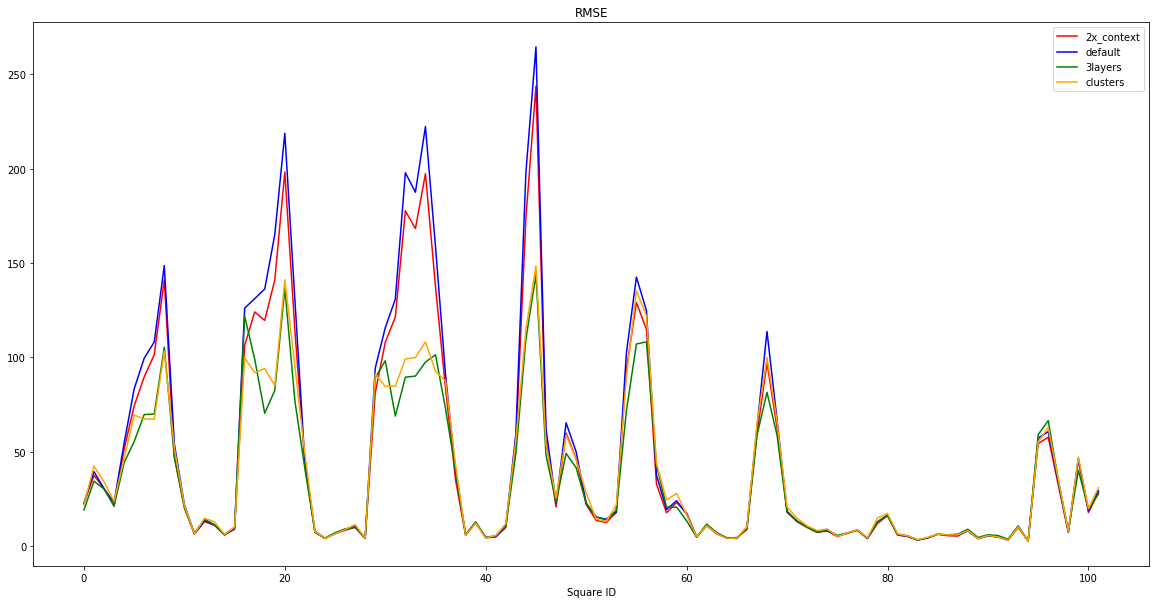

In [90]:
plt.figure(figsize=(20,10))
plt.plot(rmse_list_2x_context, color='red', label='2x_context')
plt.plot(rmse_list, color='blue', label='default')
plt.plot(rmse_list_3layers, color='green', label='3layers')
plt.plot(rmse_list_with_clusters, color='orange', label='clusters')
plt.xlabel("Square ID")
plt.title("RMSE")
plt.legend()

In [91]:
mape_with_clusters= []
for act, prd_dt in zip(act_list_with_clusters, prd_list_with_clusters):
    mape_with_clusters.append(mape(act, prd_dt['0.5'].tolist()))

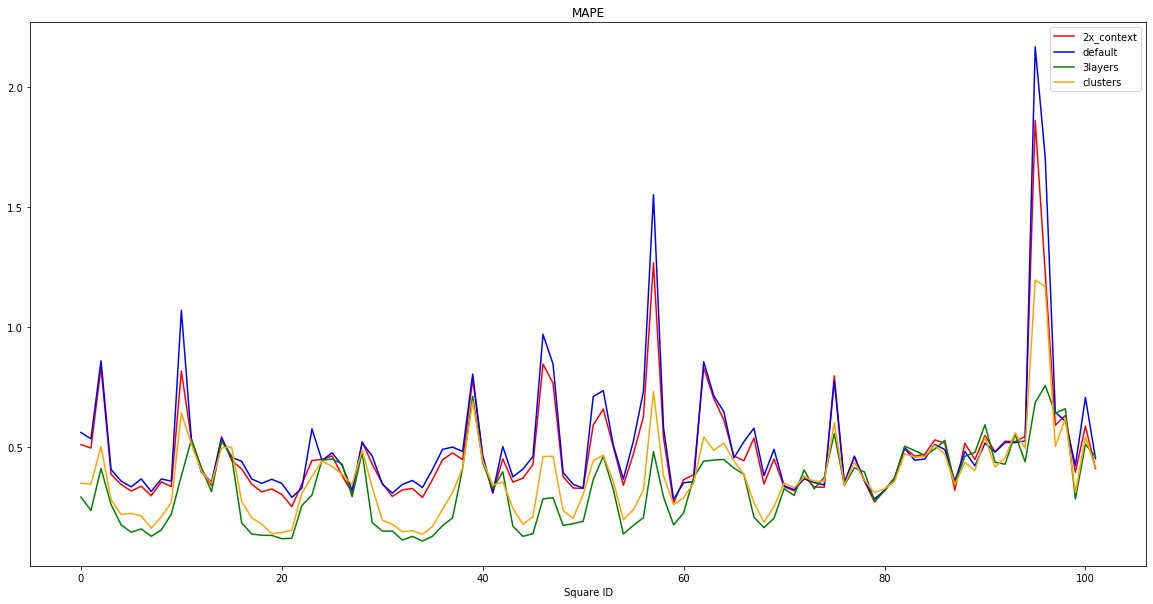

In [92]:
plt.figure(figsize=(20,10))
plt.plot(mape_list_2x_context, color='red', label='2x_context')
plt.plot(mape_list[:102], color='blue', label='default')
plt.plot(mape_list_3layers, color='green', label='3layers')
plt.plot(mape_with_clusters, color='orange', label='clusters')
plt.xlabel("Square ID")
plt.title("MAPE")
plt.legend()

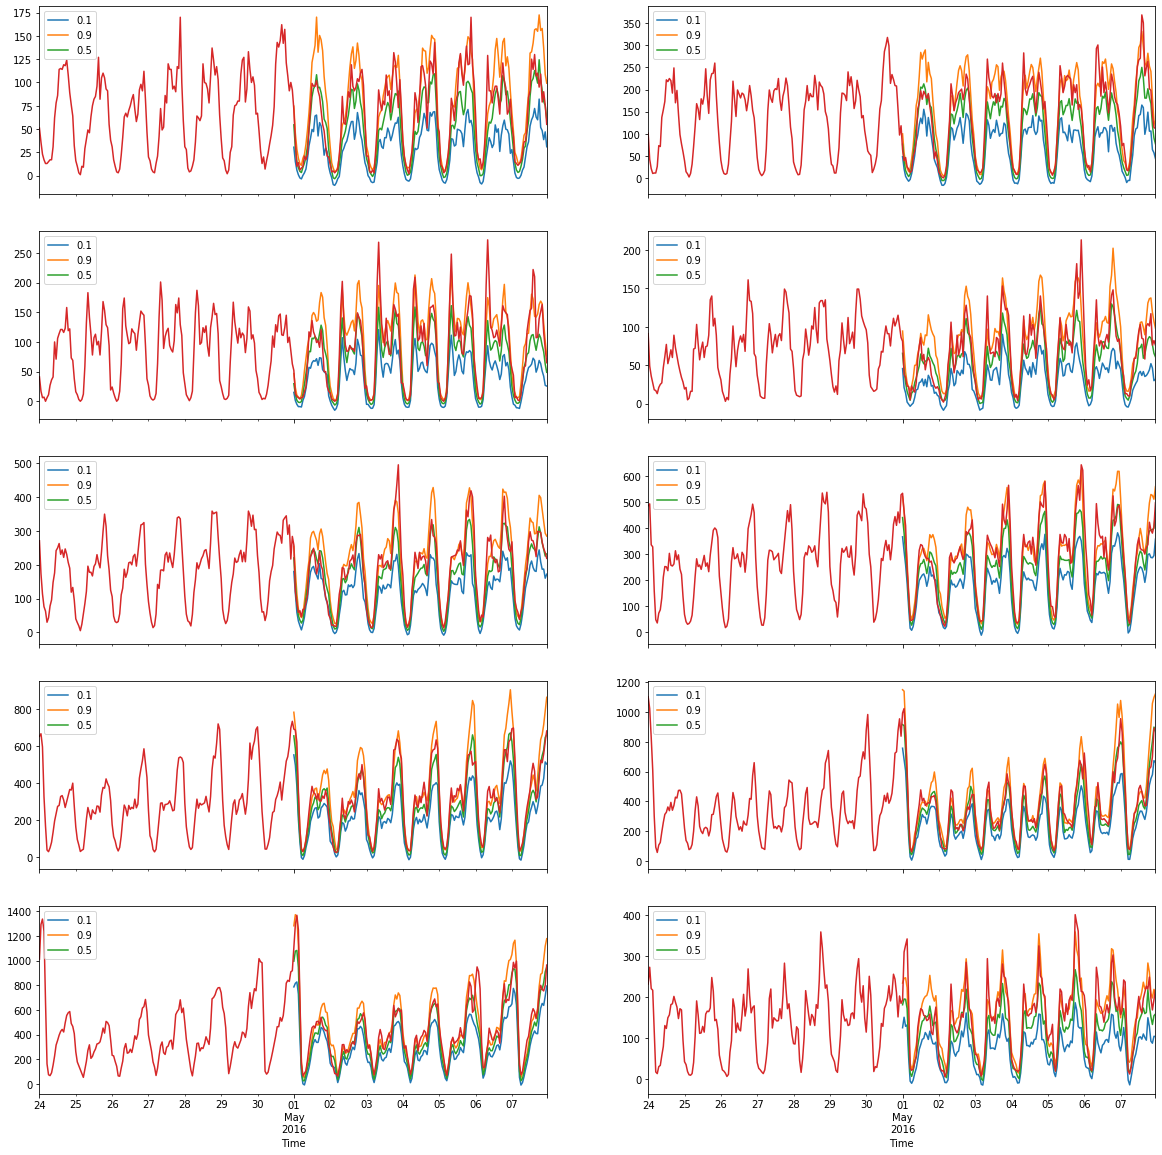

In [93]:
i = 0
start_dataset = pd.Timestamp("2016-04-24 00:00:00", freq=freq)

fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    ts = timeseries[i][start_dataset:start_predict+timedelta(hours=prediction_length)]
    prd = prd_list_with_clusters[i]
    prd.plot(ax=axx[i])
    ts.plot(ax=axx[i])

In [94]:
predictor_with_clusters.delete_endpoint()